<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We"re going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you"ll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> Preparing the tools </font></h2>

In [4]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import plotly.express as px
from datetime import datetime, date, timedelta

# Set the style
plt.style.use("ggplot")
# plt.style.available

ModuleNotFoundError: No module named 'pgeocode'

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Zicht op Data dataset </font></h3>

<h4><font color=mediumvioletred>Read CSV files </font></h4>

In [ ]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Get a sample </font></h4>

In [ ]:
# zichtop sample
df_zichtop.head(10)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
0,5611,2021-01-01 00:00:00,830,136.0,80.0,34.0,57.0,34.0,34.0,455.0
1,5611,2021-01-01 01:00:00,837,138.0,11.0,23.0,92.0,23.0,80.0,470.0
2,5611,2021-01-01 02:00:00,745,41.0,0.0,0.0,82.0,51.0,71.0,500.0
3,5611,2021-01-01 03:00:00,876,115.0,0.0,0.0,52.0,21.0,125.0,563.0
4,5611,2021-01-01 04:00:00,714,49.0,0.0,0.0,37.0,25.0,111.0,492.0
5,5611,2021-01-01 05:00:00,702,28.0,0.0,0.0,0.0,28.0,183.0,463.0
6,5611,2021-01-01 06:00:00,888,53.0,0.0,0.0,18.0,89.0,160.0,568.0
7,5611,2021-01-01 07:00:00,1182,148.0,0.0,0.0,0.0,84.0,169.0,781.0
8,5611,2021-01-01 08:00:00,1263,134.0,38.0,0.0,19.0,115.0,268.0,689.0
9,5611,2021-01-01 09:00:00,1514,214.0,71.0,0.0,71.0,160.0,303.0,695.0


In [ ]:
# air_pollution sample
df_air_pollution.sample(5)

,date,PC4,pm10,pm2.5,no2,no,so2
36451,2021-11-08 19:00:00,5644,30.886024,19.130167,47.085837,30.806159,11.117792
71933,2021-12-24 04:00:00,5653,27.460460,40.214270,20.133174,0.382880,1.776541
58017,2021-12-07 08:00:00,5622,25.275116,34.848068,25.714808,3.702223,5.996685
64726,2021-12-15 21:00:00,5645,33.357890,57.297830,46.337939,6.166728,3.403487
42472,2021-10-22 16:00:00,5652,6.766477,4.266684,23.124389,15.129255,1.818751


<h4><font color=mediumvioletred>Get number of rows and columns </font></h4>

In [ ]:
df_zichtop.shape

(255024, 10)

<h4><font color=mediumvioletred>Get types of columns </font></h4>

In [ ]:
df_zichtop.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
dtype: object

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..) </font></h4>

In [ ]:
df_zichtop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PC4      255024 non-null  int64         
 1   date     255024 non-null  datetime64[ns]
 2   pop_tot  255024 non-null  int64         
 3   m00_30   254276 non-null  float64       
 4   m30_60   254276 non-null  float64       
 5   H1_2     254276 non-null  float64       
 6   H2_4     254276 non-null  float64       
 7   H4_8     254276 non-null  float64       
 8   H8_16    254276 non-null  float64       
 9   H16plus  254276 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 19.5 MB


<h4><font color=mediumvioletred>Get some info about numerical columns (count, mean, min...) </font></h4>

In [ ]:
df_zichtop.describe()

,PC4,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
count,255024.000000,255024.000000,254276.000000,254276.000000,254276.00000,254276.000000,254276.000000,254276.000000,254276.000000
mean,5633.818182,1984.896131,334.580322,41.012966,73.50676,126.323121,237.291384,349.584455,827.626296
std,15.168687,1285.972747,376.307733,61.055502,104.01577,186.176472,331.758108,380.206726,538.795020
min,5611.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-3.000000
25%,5622.000000,1060.000000,56.000000,0.000000,0.00000,9.000000,38.000000,98.000000,471.000000
50%,5631.000000,1703.000000,222.000000,15.000000,32.00000,62.000000,119.000000,236.000000,781.000000
75%,5646.000000,2615.000000,481.000000,60.000000,107.00000,173.000000,292.000000,454.000000,1093.000000
max,5658.000000,11617.000000,4885.000000,2090.000000,1564.00000,5326.000000,3515.000000,3368.000000,3409.000000


<h4><font color=mediumvioletred>Get start and end dates </font></h4>

In [ ]:
df_zichtop["date"].min(), df_zichtop["date"].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-11-18 23:00:00'))

<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets </font></h4>

In [ ]:
df_zichtop_air_pollution = pd.merge(df_zichtop, df_air_pollution[["PC4","date", "pm2.5"]], on=["PC4", "date"])
df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,pm2.5
12928,5623,2021-11-07 16:00:00,2921,392.0,109.0,207.0,294.0,436.0,447.0,1036.0,5.552935
5093,5614,2021-11-11 05:00:00,1360,180.0,0.0,26.0,51.0,26.0,180.0,897.0,26.175480
18551,5628,2021-09-27 23:00:00,2126,0.0,0.0,0.0,0.0,24.0,97.0,2005.0,4.797853
23333,5632,2021-11-01 05:00:00,2367,182.0,0.0,0.0,0.0,8.0,285.0,1892.0,2.256881
25067,5633,2021-11-18 11:00:00,2102,578.0,32.0,289.0,257.0,433.0,481.0,32.0,5.499017


In [ ]:
df_zichtop_air_pollution.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
pm2.5             float64
dtype: object

<h4><font color=mediumvioletred>Reorder columns in zichtop air pollution dataset </font></h4>

In [ ]:
zichtop_air_pollution_features = [
    "PC4",
    "date",
    "pop_tot",
    "pm2.5",
    "m00_30",
    "m30_60",
    "H1_2",
    "H2_4",
    "H4_8",
    "H8_16",
    "H16plus"
]

df_zichtop_air_pollution = df_zichtop_air_pollution.reindex(zichtop_air_pollution_features, axis=1)

df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
42762,5658,2021-10-16 18:00:00,2136,9.767328,240.0,0.0,0.0,38.0,152.0,645.0,1061.0
27533,5642,2021-11-11 05:00:00,1543,23.660133,92.0,0.0,26.0,26.0,13.0,327.0,1059.0
23227,5632,2021-10-27 19:00:00,2832,8.134467,437.0,0.0,14.0,99.0,85.0,479.0,1718.0
27781,5643,2021-09-27 13:00:00,3068,3.446546,549.0,65.0,145.0,145.0,565.0,533.0,1066.0
8556,5617,2021-10-21 12:00:00,2974,2.359660,551.0,220.0,193.0,468.0,1377.0,165.0,0.0


<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [ ]:
df_zichtop_air_pollution.rename(columns={"date": "date_time"}, inplace=True)

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [ ]:
df_zichtop_air_pollution["date"] = df_zichtop_air_pollution["date_time"].dt.date.astype(str)
df_zichtop_air_pollution["time"] = df_zichtop_air_pollution["date_time"].dt.time.astype(str)

In [ ]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
32414,5646,2021-10-25 14:00:00,2297,4.389129,1074.0,60.0,119.0,119.0,358.0,268.0,299.0,2021-10-25,14:00:00
43424,5658,2021-11-13 08:00:00,2314,8.261040,55.0,12.0,18.0,37.0,61.0,282.0,1849.0,2021-11-13,08:00:00
12673,5623,2021-10-28 01:00:00,1124,6.753140,44.0,0.0,0.0,15.0,44.0,44.0,977.0,2021-10-28,01:00:00
9109,5617,2021-11-13 13:00:00,1523,7.115938,459.0,48.0,193.0,363.0,290.0,121.0,49.0,2021-11-13,13:00:00
5848,5615,2021-10-18 16:00:00,2630,9.864697,609.0,0.0,196.0,196.0,283.0,413.0,933.0,2021-10-18,16:00:00


<h4><font color=mediumvioletred>Get start and end dates </font></h4>

In [ ]:
df_zichtop_air_pollution["date"].min(), df_zichtop_air_pollution["date"].max()

('2021-09-25', '2021-11-18')

<h4><font color=mediumvioletred>Correlation between numerical columns </font></h4>

In [ ]:
df_zichtop_air_pollution.corr(numeric_only=True)

,PC4,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
PC4,1.000000,-0.085402,-0.040311,0.050393,-0.068758,-0.123084,-0.137336,-0.118519,-0.033977,-0.052989
pop_tot,-0.085402,1.000000,-0.016892,0.750560,0.708953,0.749542,0.761389,0.815847,0.842051,0.199654
pm2.5,-0.040311,-0.016892,1.000000,-0.094783,-0.025442,-0.015412,-0.017758,0.005160,0.018352,0.025760
m00_30,0.050393,0.750560,-0.094783,1.000000,0.640048,0.621415,0.589695,0.550787,0.616381,-0.189647
m30_60,-0.068758,0.708953,-0.025442,0.640048,1.000000,0.749745,0.676787,0.609642,0.572131,-0.137459
H1_2,-0.123084,0.749542,-0.015412,0.621415,0.749745,1.000000,0.805084,0.656044,0.571656,-0.132161
H2_4,-0.137336,0.761389,-0.017758,0.589695,0.676787,0.805084,1.000000,0.724193,0.540605,-0.144004
H4_8,-0.118519,0.815847,0.005160,0.550787,0.609642,0.656044,0.724193,1.000000,0.692728,-0.154635
H8_16,-0.033977,0.842051,0.018352,0.616381,0.572131,0.571656,0.540605,0.692728,1.000000,-0.002266
H16plus,-0.052989,0.199654,0.025760,-0.189647,-0.137459,-0.132161,-0.144004,-0.154635,-0.002266,1.000000


<h4><font color=mediumvioletred>Visualize correlation between numerical columns </font></h4>

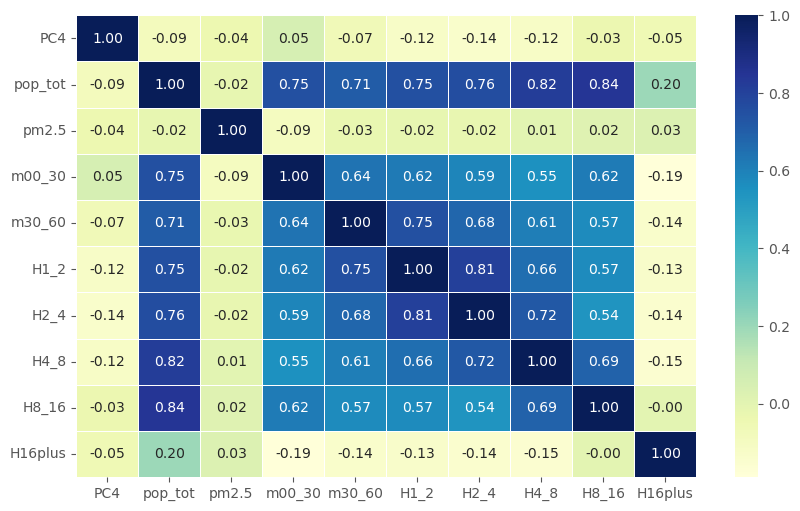

In [ ]:
corr_matrix = df_zichtop_air_pollution.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

The correlation matrix demonstrates that PC4, m00_30 and m30_60 have the highest coreelation with our target column pm2.5.

<h4><font color=mediumvioletred>Get number of people in zip code 5611 on 2021-09-25 </font></h4>

In [ ]:
people_air_quality_area = df_zichtop_air_pollution[(df_zichtop_air_pollution["PC4"] == 5611) & (df_zichtop_air_pollution["date"] == "2021-09-25")]
people_air_quality_area.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
9,5611,2021-09-25 09:00:00,5693,9.297590,631.0,166.0,880.0,963.0,913.0,1029.0,1111.0,2021-09-25,09:00:00
6,5611,2021-09-25 06:00:00,2771,13.031172,513.0,16.0,16.0,64.0,224.0,529.0,1409.0,2021-09-25,06:00:00
0,5611,2021-09-25 00:00:00,1438,4.531522,155.0,0.0,0.0,0.0,0.0,77.0,1206.0,2021-09-25,00:00:00
13,5611,2021-09-25 13:00:00,8282,4.508791,1004.0,329.0,906.0,1630.0,1712.0,1712.0,989.0,2021-09-25,13:00:00
18,5611,2021-09-25 18:00:00,6851,13.518612,801.0,166.0,442.0,1160.0,1892.0,1340.0,1050.0,2021-09-25,18:00:00


<h4><font color=mediumvioletred>Visualize number of people in zip code 5611 on 2021-09-25 </font></h4>

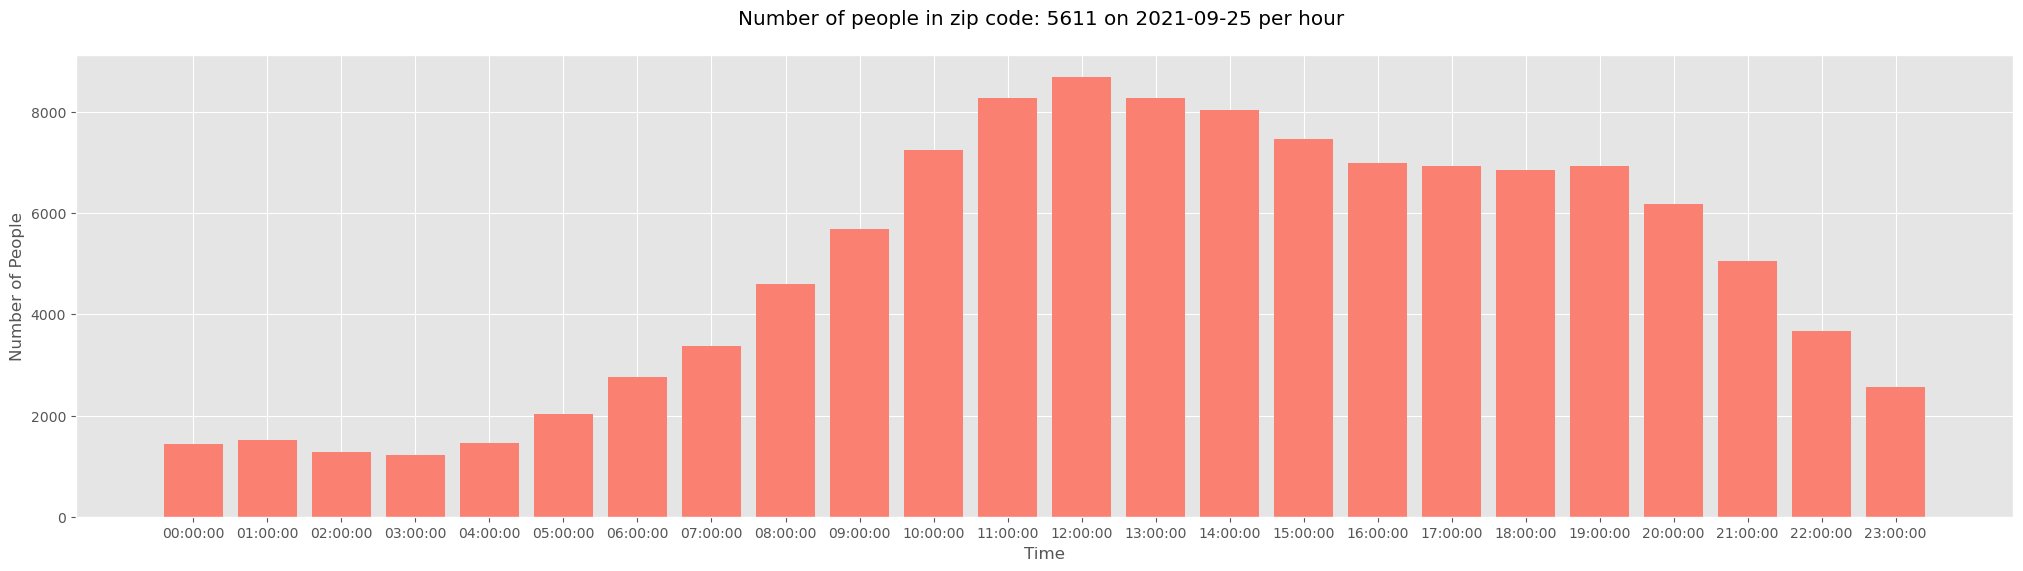

In [ ]:
fig, ax = plt.subplots(figsize=(25, 6))
# Plot the data
barplot = ax.bar(list(people_air_quality_area["time"]),
                list(people_air_quality_area["pop_tot"]),
                color="salmon");

# Customize the plot
ax.set(title="Number of people in zip code: 5611 on 2021-09-25 per hour \n",
      xlabel="Time",
      ylabel="Number of People");

The bar chart shows that on September 25, 2021, the population of zip code 5611 starts increasing at 5 AM, peaks at 12 PM, and then begins to decline around 7 PM.

<h4><font color=mediumvioletred> Get maximum number of people per zip code </font></h4>

In [ ]:
max_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg("max").reset_index()
max_people.head()

,PC4,pop_tot
0,5611,11617
1,5612,10250
2,5613,5925
3,5614,3504
4,5615,4408


<h4><font color=mediumvioletred> Visualize maximum number of people per zip code </font></h4>

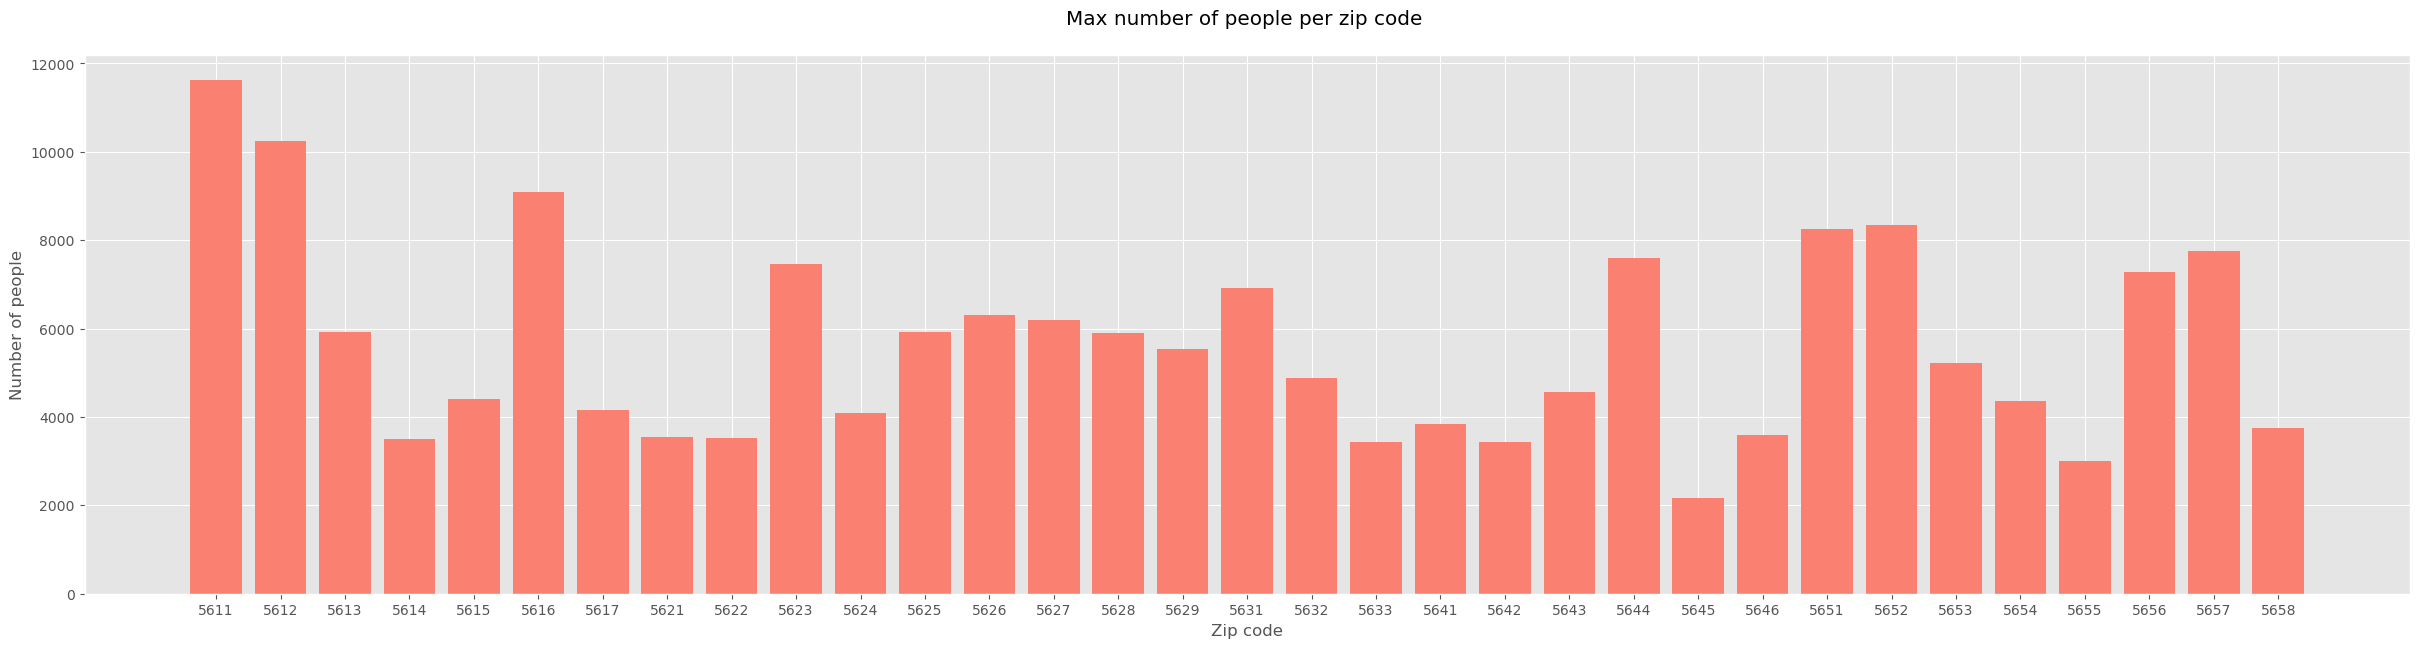

In [ ]:
fig, ax = plt.subplots(figsize=(30, 7))
# Plot the data
barplot = ax.bar(max_people["PC4"].astype(str),
                max_people["pop_tot"],
                color="salmon");

# Customize the plot
ax.set(title="Max number of people per zip code \n",
      xlabel="Zip code",
      ylabel="Number of people");

According to the graph, zip codes 5611, 5612 and 5616 have the highest number of people. These areas are at the city center of Eindhoven, so that is to be expected.

<h4><font color=mediumvioletred> Get maximum, average and minimum number of people per zip code </font></h4>

In [ ]:
max_mean_min_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_people.head()

,PC4,max,min,mean
0,5611,11617,708,4676.526515
1,5612,10250,737,4052.258333
2,5613,5925,537,2504.754545
3,5614,3504,217,1509.311364
4,5615,4408,394,1933.862121


<h4><font color=mediumvioletred> Visualize maximum, average and minimum number of people per zip code </font></h4>

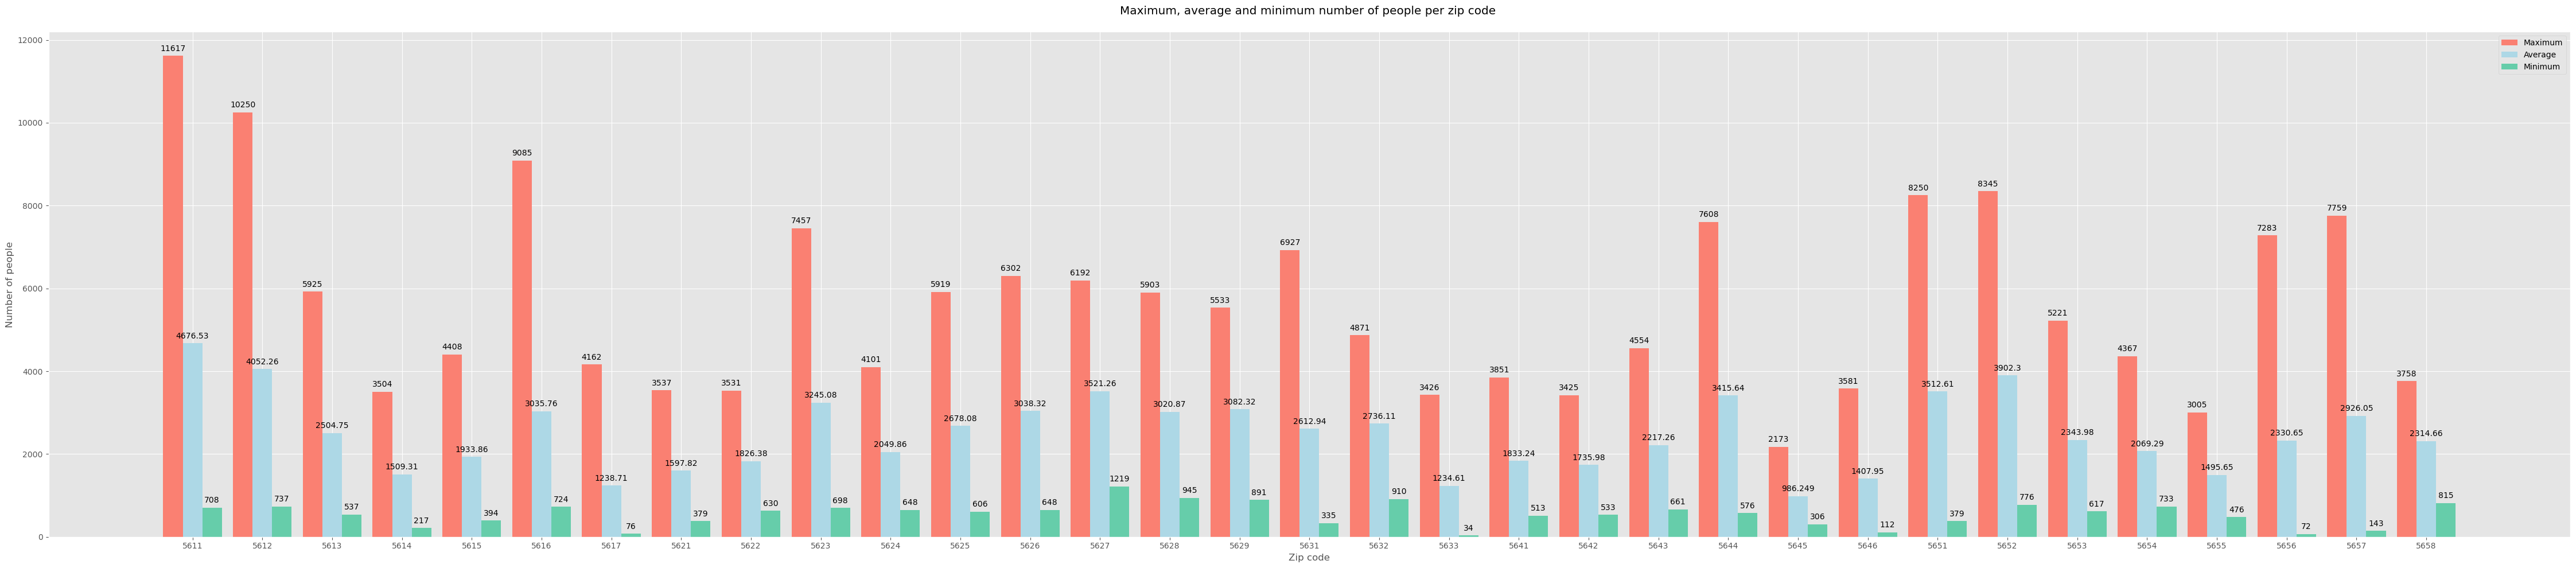

In [ ]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_people["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, max_mean_min_people["max"], width, label="Maximum", color="salmon")
rects2 = ax.bar(x, max_mean_min_people["mean"], width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, max_mean_min_people["min"], width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Number of people")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum number of people per zip code \n")
ax.set_xticks(x, max_mean_min_people["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

plt.show()

The graph shows that zip codes 5611, 5612 and 5616 have the highest number of people, while zip codes 5633, 5656, 5617 have the lowest number of people.

<h4><font color=mediumvioletred> Get number of people vs. air quality </font></h4>

In [ ]:
# get data for zip code 5611 on 2021-09-25
people_air_quality_area.head(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
0,5611,2021-09-25 00:00:00,1438,4.531522,155.0,0.0,0.0,0.0,0.0,77.0,1206.0,2021-09-25,00:00:00
1,5611,2021-09-25 01:00:00,1516,3.434374,130.0,0.0,0.0,0.0,29.0,72.0,1285.0,2021-09-25,01:00:00
2,5611,2021-09-25 02:00:00,1283,4.274056,44.0,0.0,0.0,0.0,15.0,73.0,1151.0,2021-09-25,02:00:00
3,5611,2021-09-25 03:00:00,1223,5.396931,14.0,0.0,0.0,14.0,14.0,86.0,1095.0,2021-09-25,03:00:00
4,5611,2021-09-25 04:00:00,1464,6.389200,56.0,0.0,14.0,28.0,28.0,155.0,1183.0,2021-09-25,04:00:00


<h4><font color=mediumvioletred> Visualize number of people vs. air quality </font></h4>

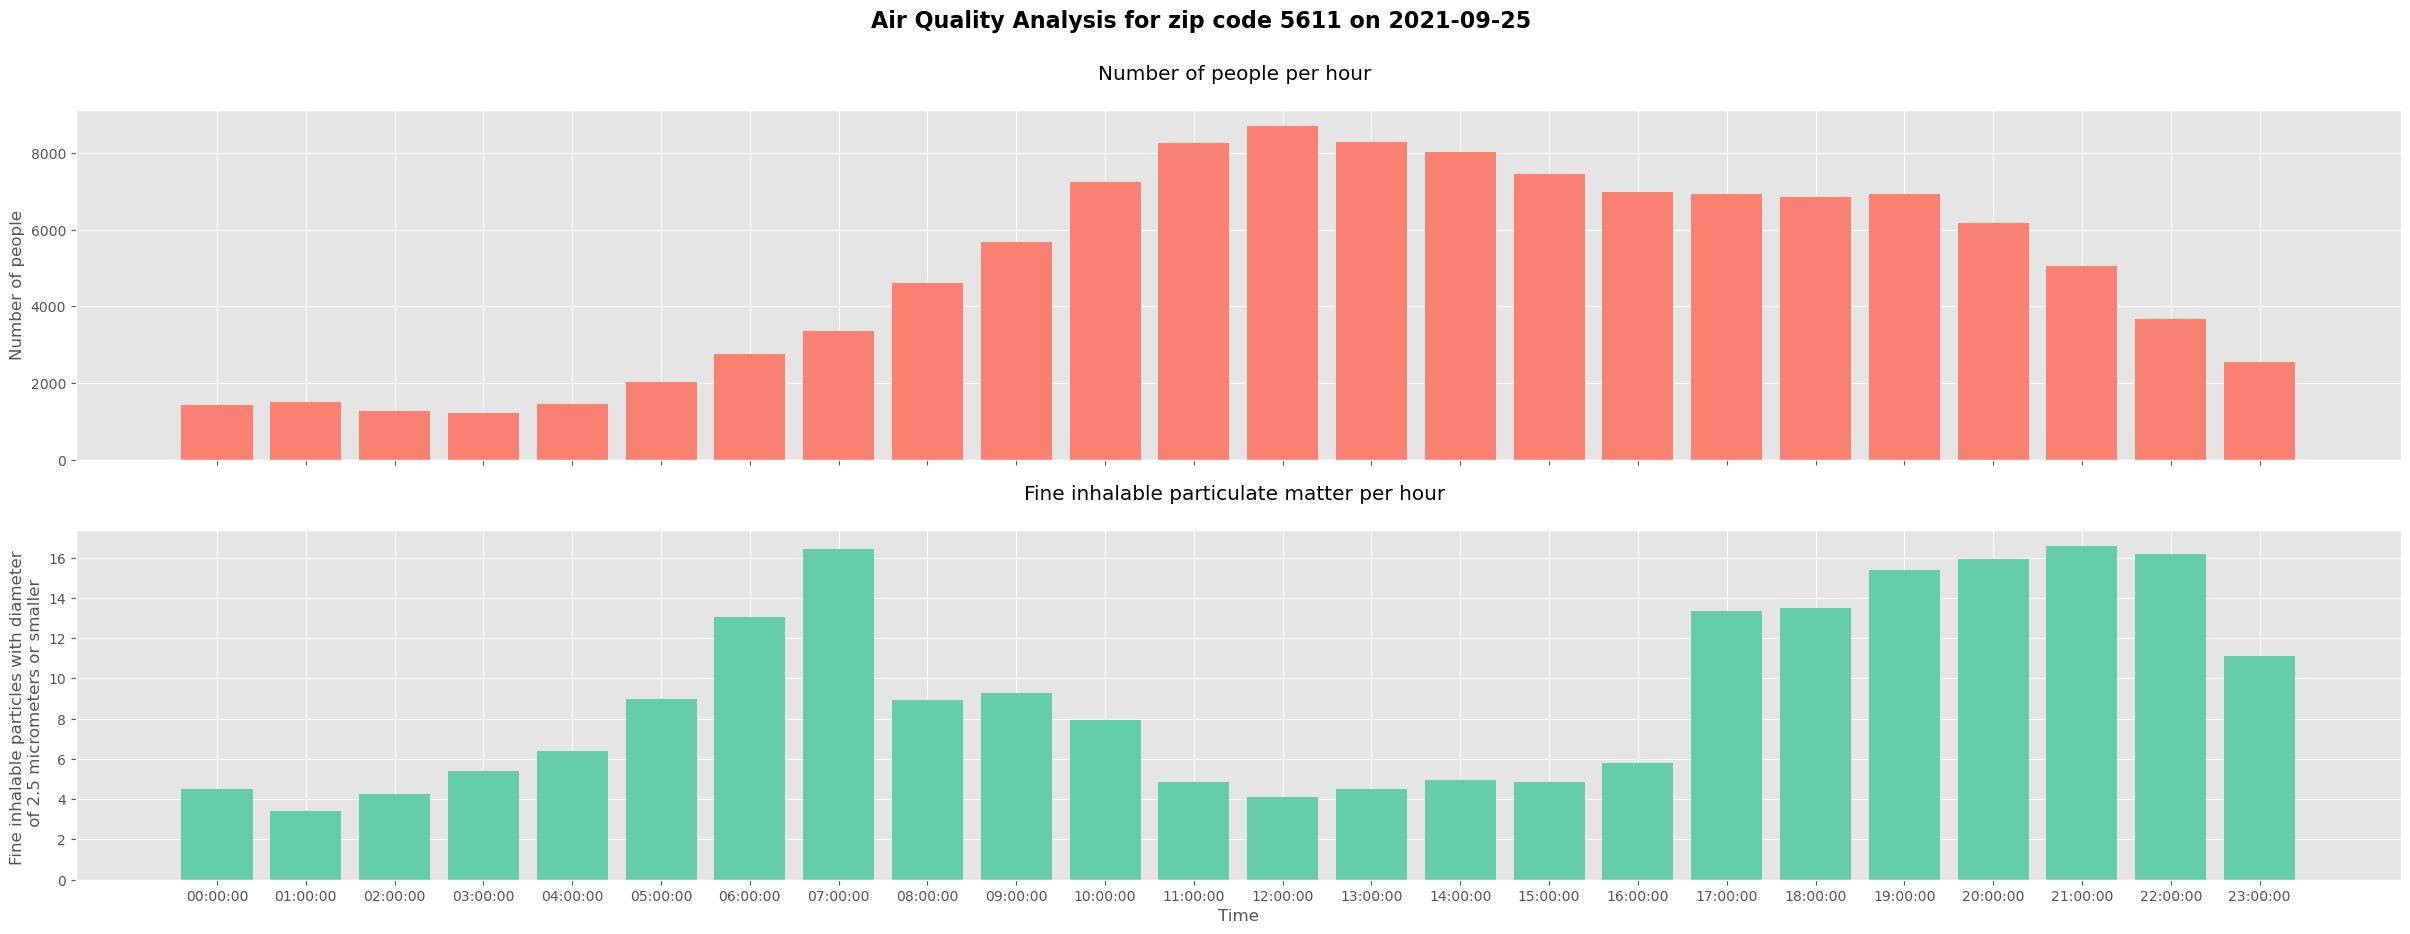

In [ ]:
# Subplot of number of people, pollution, time
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 10),
                                sharex=True)

# Add data to ax0
ax0.bar(people_air_quality_area["time"], people_air_quality_area["pop_tot"], color="salmon");
# Add data to ax1
ax1.bar(people_air_quality_area["time"], people_air_quality_area["pm2.5"], color="mediumaquamarine");

# Customize ax0
ax0.set(title="Number of people per hour \n",
      ylabel="Number of people");

# Customize ax1
ax1.set(title="Fine inhalable particulate matter per hour \n",
        xlabel="Time",
        ylabel="Fine inhalable particles with diameter \n of 2.5 micrometers or smaller");

# Add a title to the figure
fig.suptitle("Air Quality Analysis for zip code 5611 on 2021-09-25", fontsize=16, fontweight="bold");

The bar chart illustrates that the pm2.5 in zip code 5611 on September 25, 2021 increases during the rush hours because of traffic, and decreases and stabilizes during the off-peak hours.

<h4><font color=mediumvioletred> Get maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

In [ ]:
# Get daily average of pm2.5 per zip code
average_pm_per_day = df_zichtop_air_pollution.groupby(["PC4", "date"])["pm2.5"].agg({"mean"}).reset_index()

# Get maximum, average and minimum of pm2.5 per zip code
max_mean_min_pm = average_pm_per_day.groupby(["PC4"])["mean"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_pm.head()

,PC4,max,min,mean
0,5611,36.353814,2.800860,11.384660
1,5612,36.713622,2.803116,11.319719
2,5613,33.850463,2.651556,10.836317
3,5614,33.032114,2.573862,10.658091
4,5615,35.662240,2.660535,11.044525


<h4><font color=mediumvioletred> Visualize maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

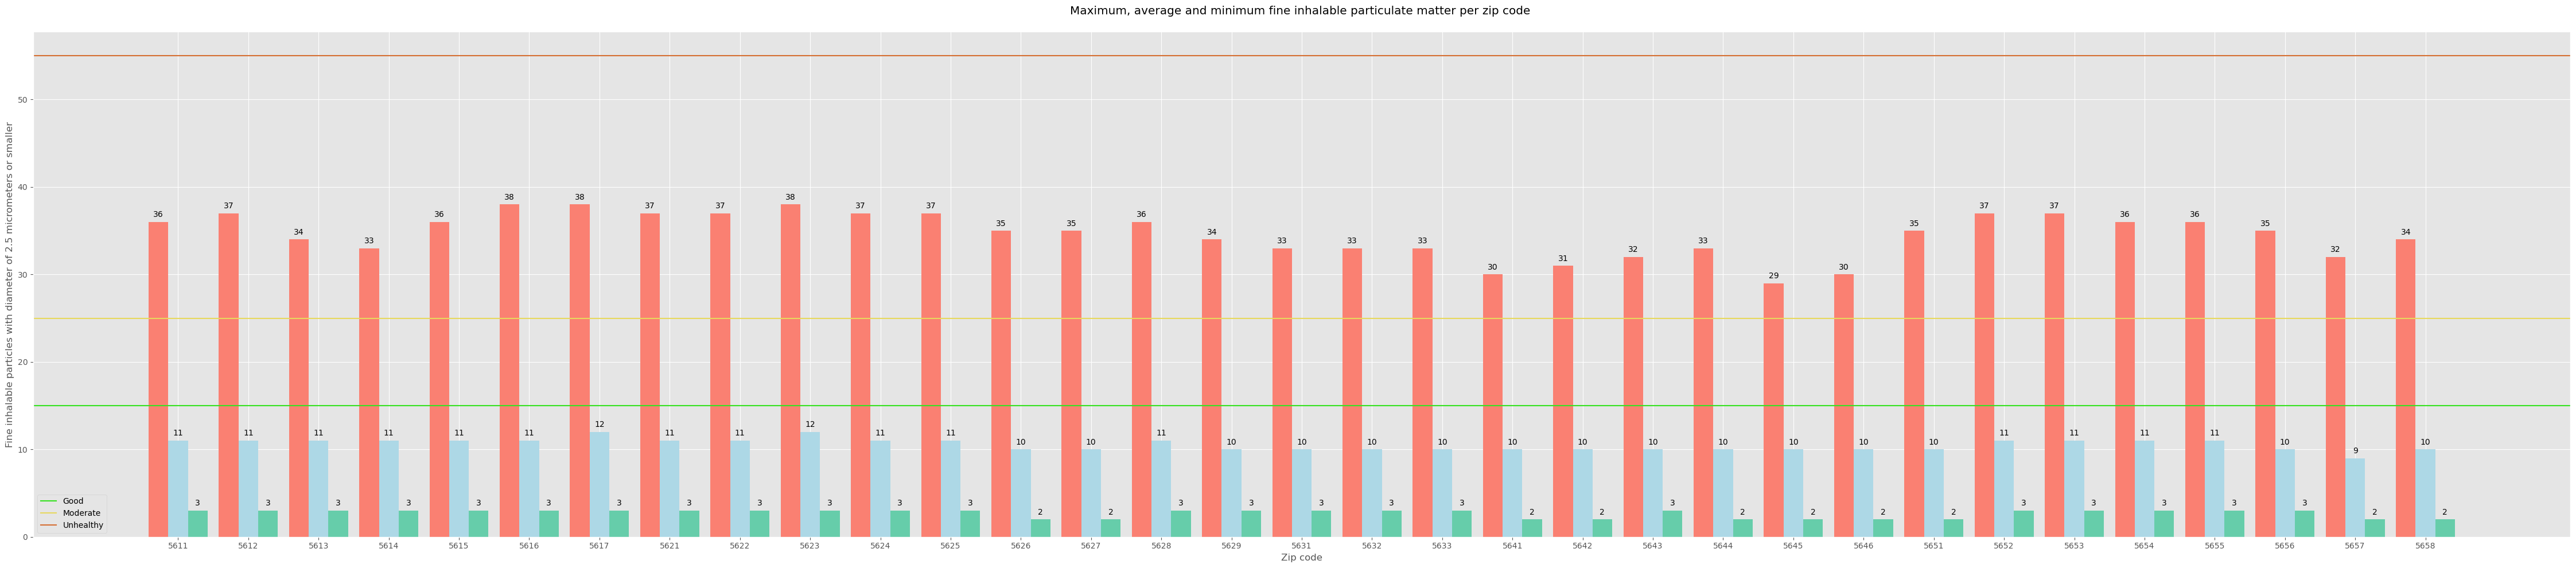

In [ ]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_pm["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, round(max_mean_min_pm["max"]), width, label="Maximum", color="salmon")
rects2 = ax.bar(x, round(max_mean_min_pm["mean"]), width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, round(max_mean_min_pm["min"]), width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Fine inhalable particles with diameter of 2.5 micrometers or smaller")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum fine inhalable particulate matter per zip code \n")
ax.set_xticks(x, max_mean_min_pm["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

# adding air quality limits
good_limit = [15]
moderate_limit = [25]
unhealthy_limit = [55]

plt.axhline(y = good_limit, color = '#36e221', linestyle = '-')
plt.axhline(y = moderate_limit, color = '#e7d85d', linestyle = '-')
plt.axhline(y = unhealthy_limit, color = '#d56f33', linestyle = '-')
plt.legend(['Good', 'Moderate', 'Unhealthy'])

plt.show()

The graph indicates, that for each zip code the average and minimum pm2.5 levels are good while the maximum pm2.5 levels are unhealthy.

![title](images/pm2.5_chart.jpg)

<h4><font color=mediumvioletred>Calculate number of people per hour </font></h4>

In [ ]:
# Get specific columns
people_per_hour = df_zichtop_air_pollution.iloc[:, [0, 3, 4, 5, 11, 12]].copy()
# Calculate number of people per hour
people_per_hour["people_number"] = people_per_hour["m00_30"] + people_per_hour["m30_60"]

people_per_hour.head(5)

,PC4,pm2.5,m00_30,m30_60,date,time,people_number
0,5611,4.531522,155.0,0.0,2021-09-25,00:00:00,155.0
1,5611,3.434374,130.0,0.0,2021-09-25,01:00:00,130.0
2,5611,4.274056,44.0,0.0,2021-09-25,02:00:00,44.0
3,5611,5.396931,14.0,0.0,2021-09-25,03:00:00,14.0
4,5611,6.389200,56.0,0.0,2021-09-25,04:00:00,56.0


<h4><font color=mediumvioletred>Get number of people and average fine particulate matter (pm2.5) per day and area</font></h4>

In [ ]:
# Calculate people number (sum) and pm2.5 (average) per day
people_pollution_per_day_area = people_per_hour.groupby(["PC4", "date"]).agg({"people_number": "sum", "pm2.5": "mean"}).reset_index()
# Round to 2 decimal places
people_pollution_per_day_area = people_pollution_per_day_area.round(decimals=2)

people_pollution_per_day_area.head(5)

,PC4,date,people_number,pm2.5
0,5611,2021-09-25,16501.0,9.16
1,5611,2021-09-26,13175.0,8.11
2,5611,2021-09-27,24414.0,6.65
3,5611,2021-09-28,20980.0,5.89
4,5611,2021-09-29,21242.0,3.48


<h4><font color=mediumvioletred> Visualize the distribution of population </font></h4>

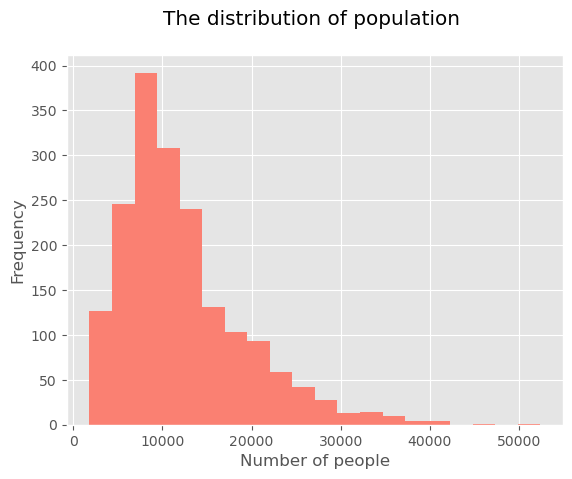

In [ ]:
ax = people_pollution_per_day_area["people_number"].plot.hist(bins=20, 
                                                         title="The distribution of population \n", 
                                                         color="salmon");

ax.set_xlabel("Number of people");

After visualizing the distribution of the population, we can see that there are a few outliers, starting around 40000.

<h4><font color=mediumvioletred> Visualize the distribution of the fine particulate matter (pm2.5) </font></h4>

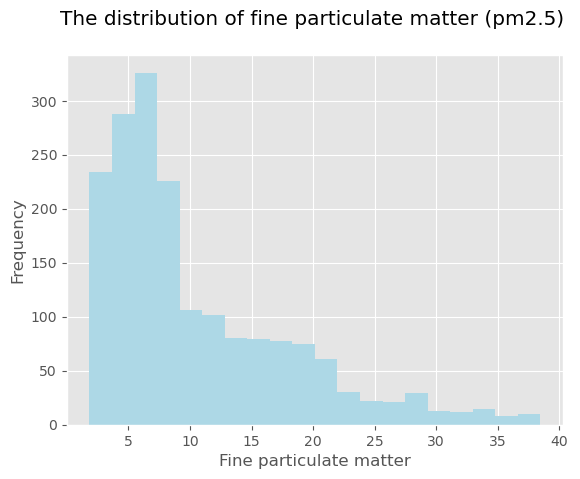

In [ ]:
ax = people_pollution_per_day_area["pm2.5"].plot.hist(bins=20,
                                                title="The distribution of fine particulate matter (pm2.5) \n", 
                                                color="lightblue");

ax.set_xlabel("Fine particulate matter");

We can observe that there are a few outliers in the graph above, starting around 35.

<h4><font color=mediumvioletred> Get number of people and fine particulate matter (pm2.5) for multiple weeks in zip code 5611 </font></h4>

In [ ]:
people_pollution_multiple_weeks_5611 = people_pollution_per_day_area[(people_pollution_per_day_area["date"] >= "2021-11-01") & 
                                                                    (people_pollution_per_day_area["date"] < "2021-11-18") & 
                                                                    (people_pollution_per_day_area["PC4"] == 5611)]
people_pollution_multiple_weeks_5611.sample(5)

,PC4,date,people_number,pm2.5
50,5611,2021-11-14,7534.0,21.23
43,5611,2021-11-07,8005.0,5.41
47,5611,2021-11-11,10902.0,32.83
48,5611,2021-11-12,14474.0,23.06
37,5611,2021-11-01,9372.0,4.83


<h4><font color=mediumvioletred> Visualize number of people for multiple weeks in zip code 5611 </font></h4>

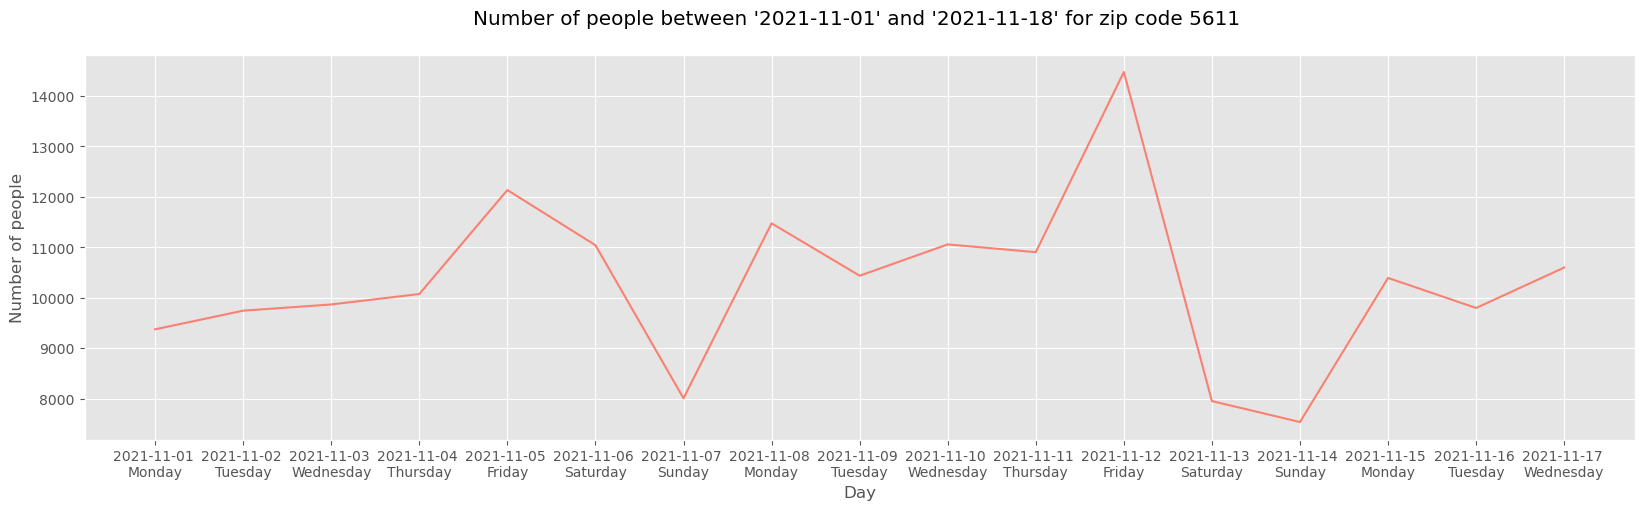

In [ ]:
plt.figure(figsize = (20 ,5))

plt.plot(people_pollution_multiple_weeks_5611["date"] + " \n" + pd.DatetimeIndex(people_pollution_multiple_weeks_5611["date"]).day_name(), 
         people_pollution_multiple_weeks_5611["people_number"], color="salmon")
 
# Adding Title to the Plot
plt.title("Number of people between '2021-11-01' and '2021-11-18' for zip code 5611 \n")

# Setting the X and Y labels
plt.xlabel("Day")
plt.ylabel("Number of people")
  
plt.show()

After looking at the population for a few weeks, we can notice a pattern. The number of people balances during the week; it begins to rise on Thursday and peaks on Friday before falling on Saturday, reaching its lowest point on Sunday, and then rising once more on Monday.

<h4><font color=mediumvioletred> Visualize the distribution of population using Boxplot and Histogram</font></h4>

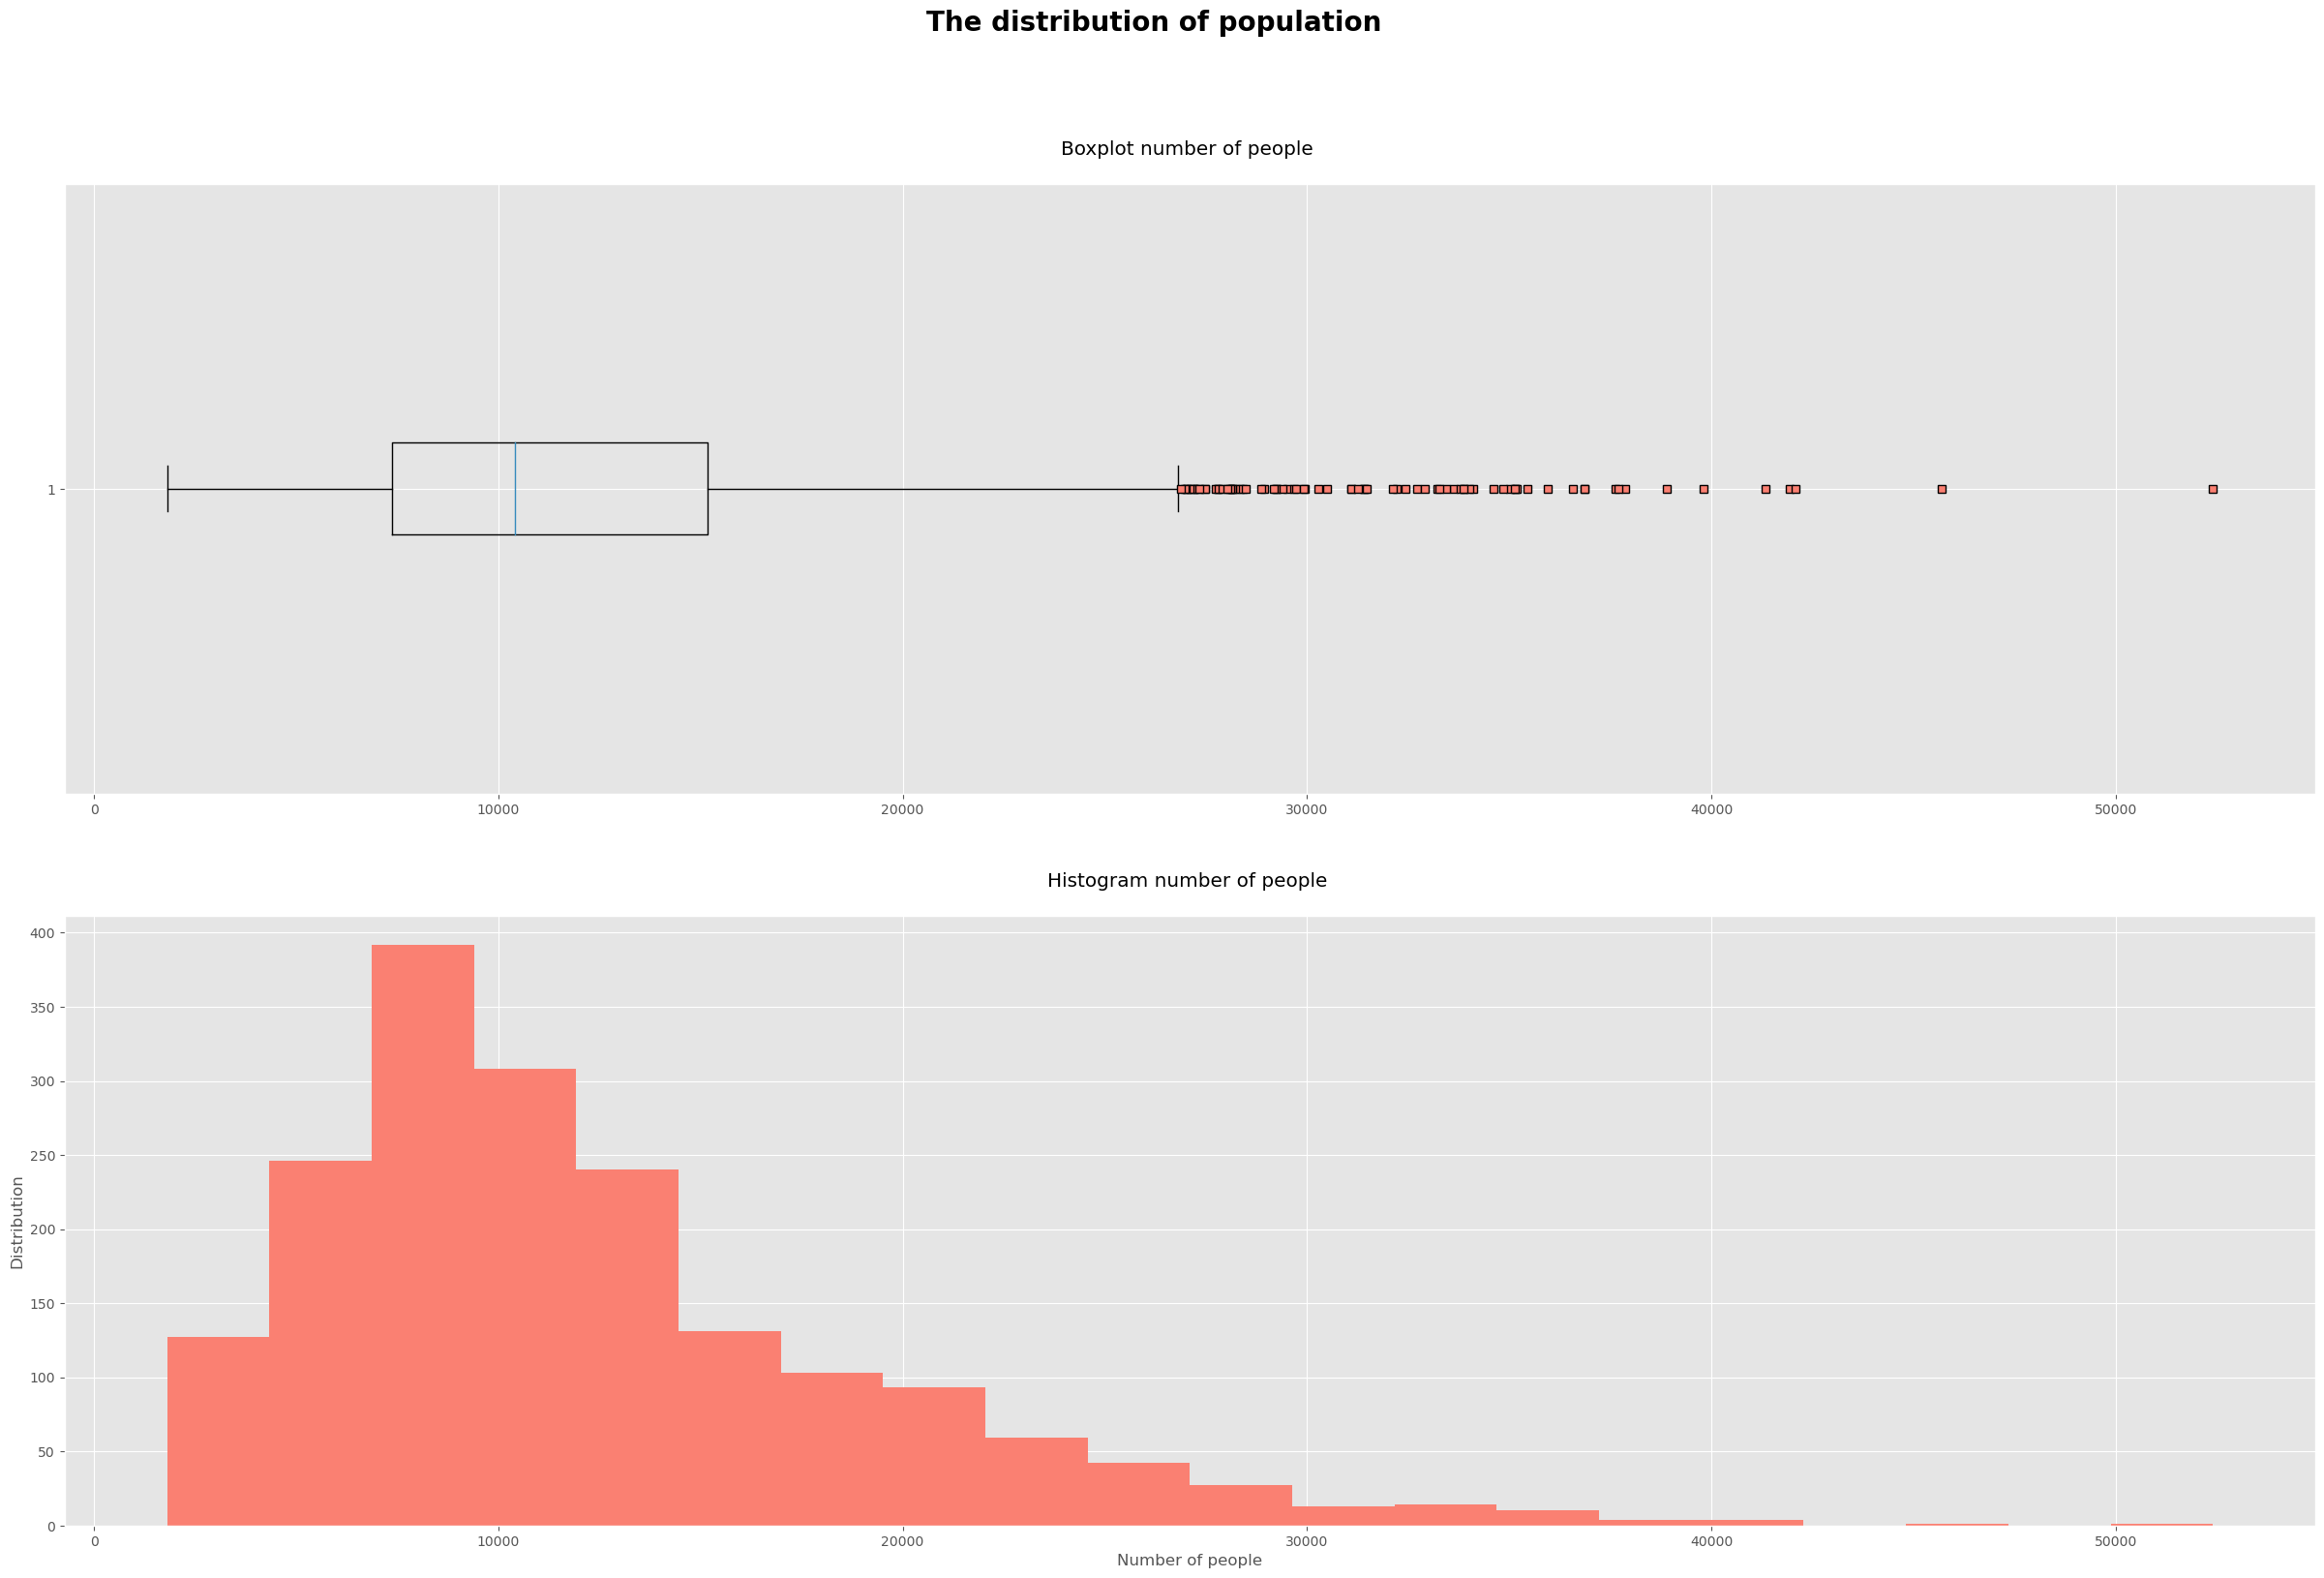

In [ ]:
# Subplot of number of people distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 18),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor="salmon", marker="s")
ax0.boxplot(people_pollution_per_day_area["people_number"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(people_pollution_per_day_area["people_number"], bins=20, color="salmon");

# Customize ax0
ax0.set(title="Boxplot number of people \n");

# Customize ax1
ax1.set(title="Histogram number of people \n",
        xlabel="Number of people",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of population", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 27000.

<h4><font color=mediumvioletred> Visualize the distribution of fine particulate matter using Boxplot and Histogram</font></h4>

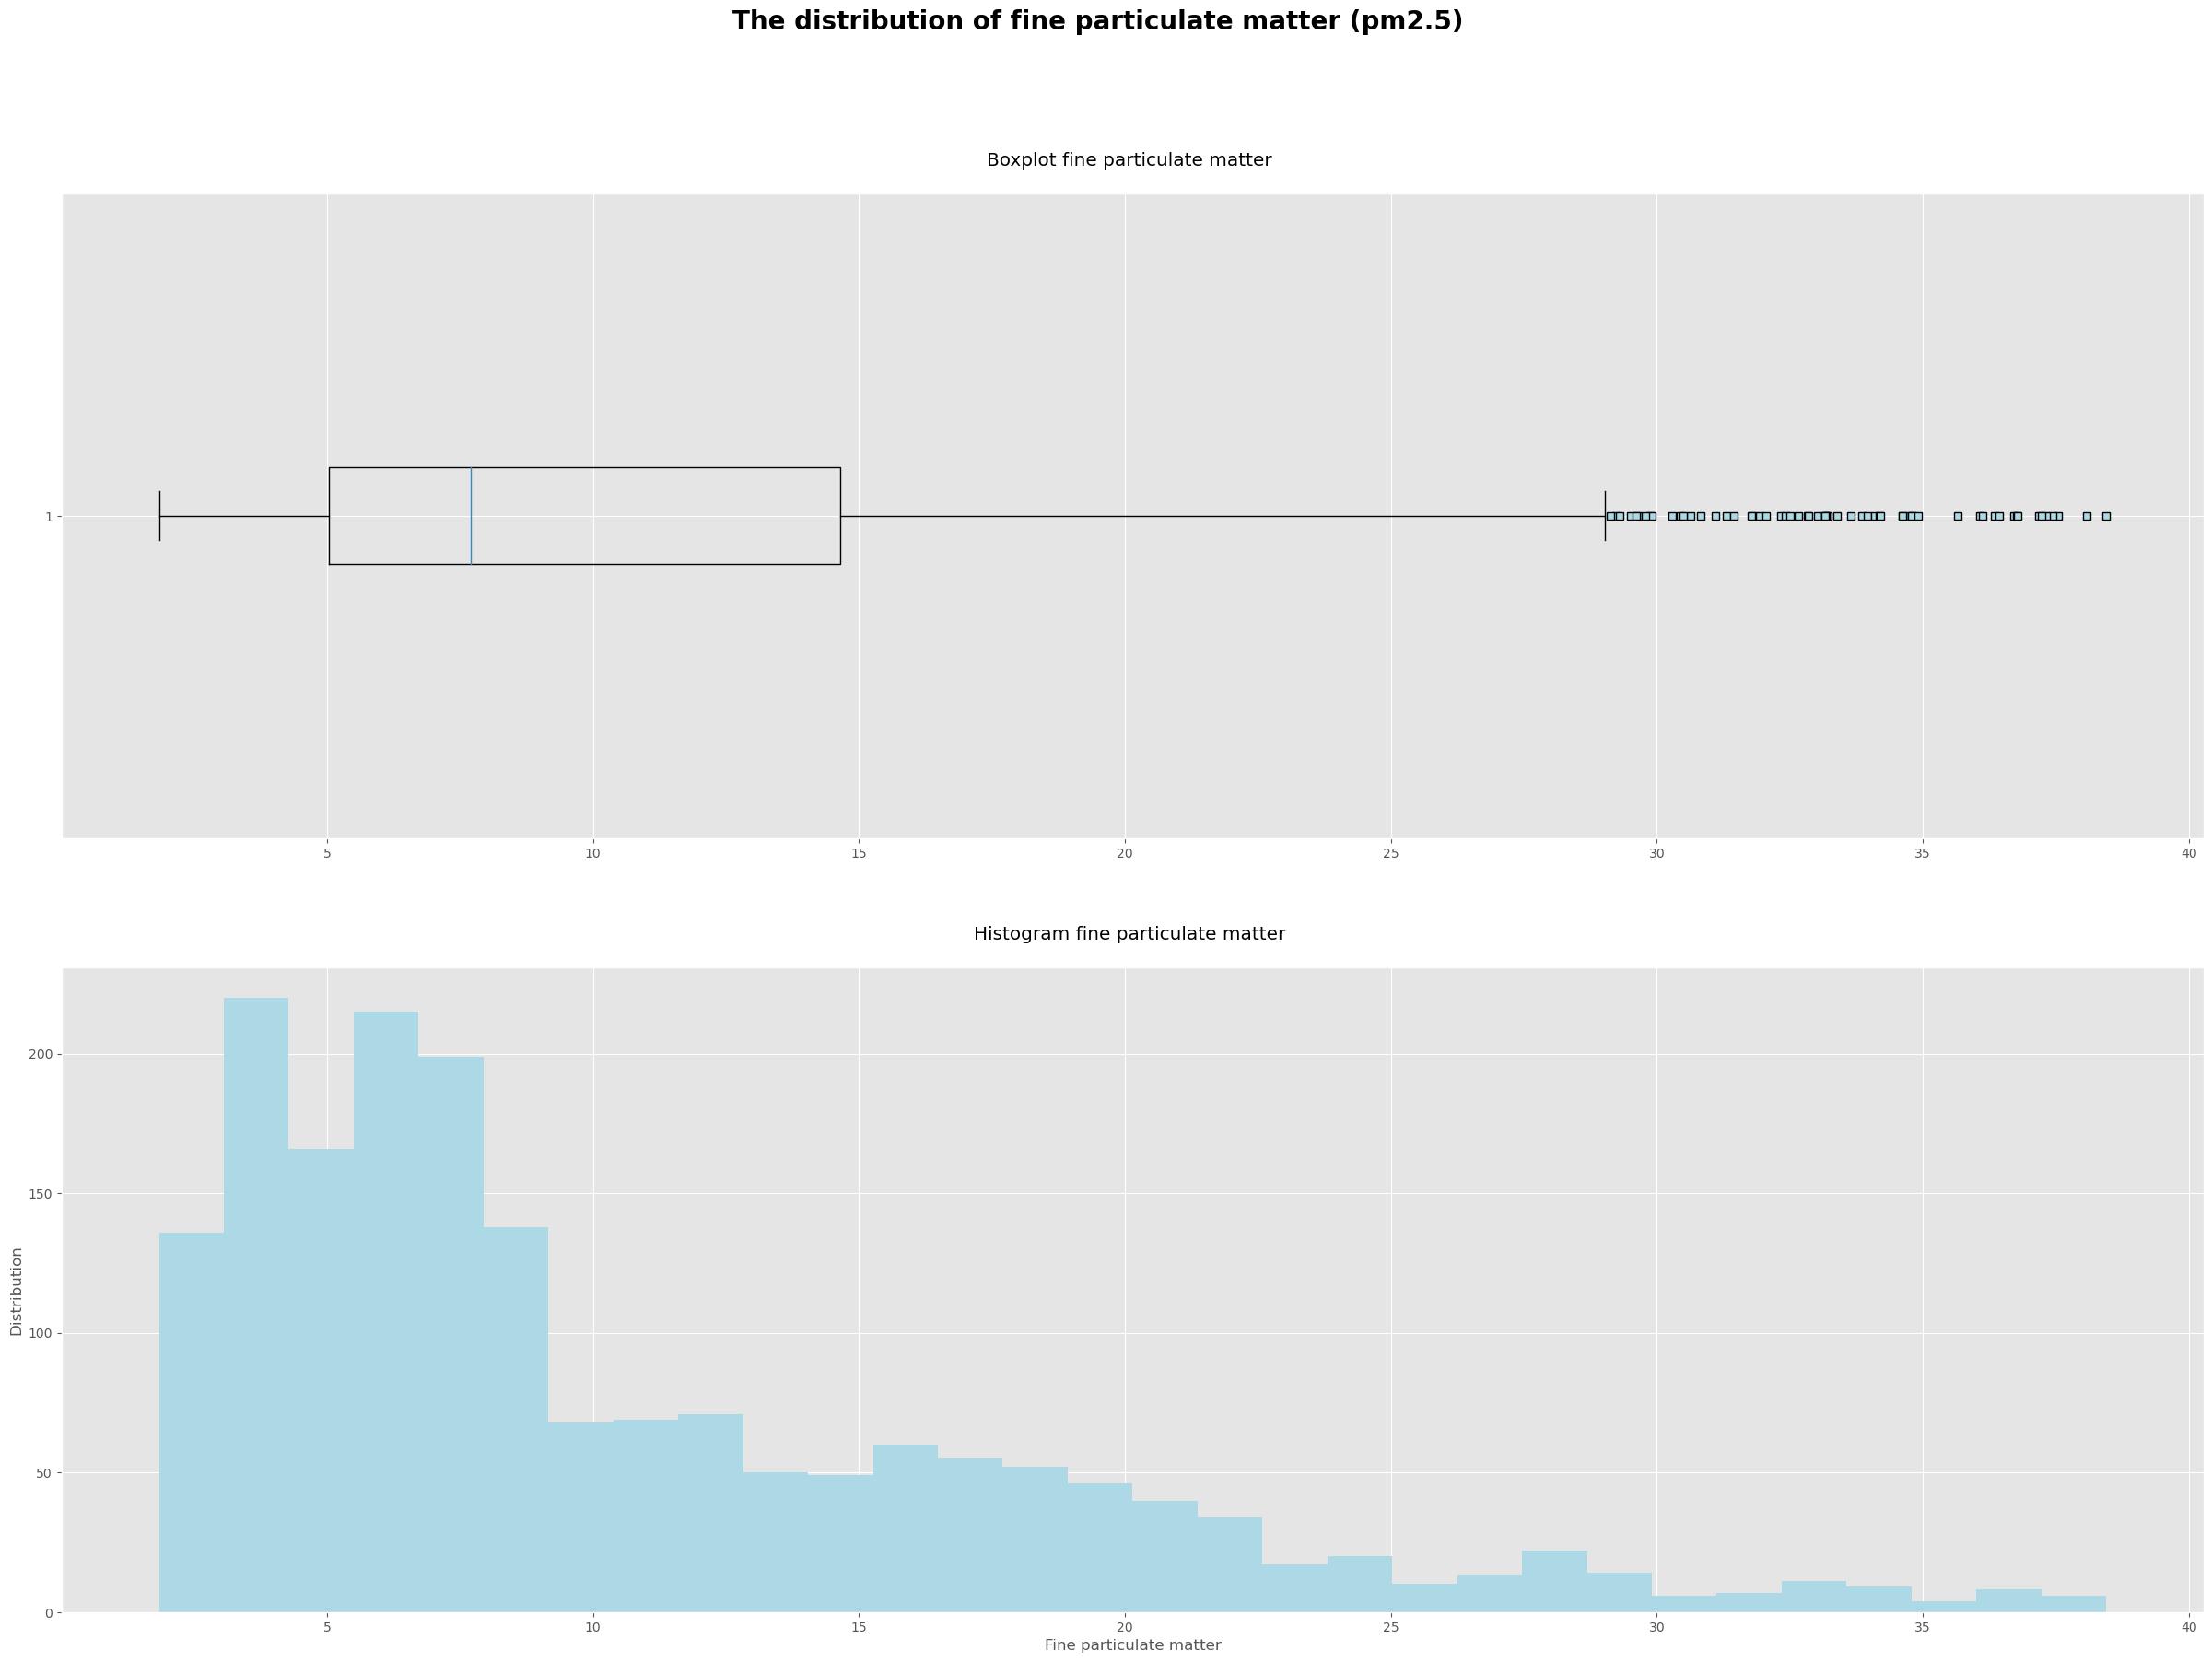

In [ ]:
# Subplot of number of people distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 20),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor="lightblue", marker="s")
ax0.boxplot(people_pollution_per_day_area["pm2.5"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(people_pollution_per_day_area["pm2.5"], bins=30, color="lightblue");

# Customize ax0
ax0.set(title="Boxplot fine particulate matter \n");

# Customize ax1
ax1.set(title="Histogram fine particulate matter \n",
        xlabel="Fine particulate matter",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of fine particulate matter (pm2.5)", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 28.

<h4><font color=mediumvioletred> Visualize the population vs fine particulate matter (pm2.5) per area</font></h4>

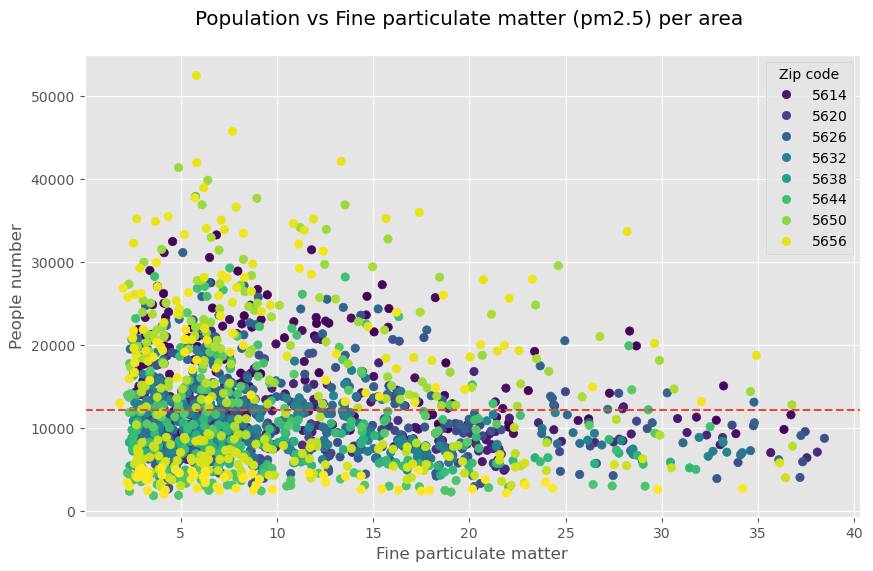

In [ ]:
# OO method
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
scatter = ax.scatter(x=people_pollution_per_day_area["pm2.5"],
                    y=people_pollution_per_day_area["people_number"],
                    c=people_pollution_per_day_area["PC4"]);

# Customize the plot
ax.set(title="Population vs Fine particulate matter (pm2.5) per area \n",
      xlabel="Fine particulate matter",
      ylabel="People number");

# Add a legend
ax.legend(*scatter.legend_elements(), title="Zip code");

# Add a horizontal line
ax.axhline(people_pollution_per_day_area["people_number"].mean(),
          linestyle="--");

The above scatter plot confirms our previous findings, that both the people number and fine particulate matter have some outliers which need to be handled in order to produce an accurate model.

<h4><font color=mediumvioletred>Specify country code in Pgeocode library </font></h4>

In [ ]:
nomi = pgeocode.Nominatim('nl')

<h4><font color=mediumvioletred>Get postal code information for zip code 5621 </font></h4>

In [ ]:
nomi.query_postal_code("5621")

postal_code                5621
country_code                 NL
place_name            Eindhoven
state_name        Noord-Brabant
state_code                    6
county_name           Eindhoven
county_code                 772
community_name              NaN
community_code              NaN
latitude                51.4549
longitude                 5.457
accuracy                    6.0
Name: 0, dtype: object

<h4><font color=mediumvioletred>Get sample of of zichtop air pollution dataframe </font></h4>

In [ ]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
8566,5617,2021-10-21 22:00:00,464,7.147669,135.0,0.0,58.0,39.0,58.0,97.0,77.0,2021-10-21,22:00:00
980,5611,2021-11-04 20:00:00,3808,28.835238,184.0,35.0,70.0,989.0,937.0,875.0,718.0,2021-11-04,20:00:00
28531,5643,2021-10-28 19:00:00,1999,8.123156,264.0,17.0,17.0,83.0,66.0,413.0,1139.0,2021-10-28,19:00:00
31778,5646,2021-09-29 02:00:00,480,1.359599,114.0,0.0,0.0,23.0,23.0,46.0,274.0,2021-09-29,02:00:00
29027,5643,2021-11-18 11:00:00,2714,8.434010,319.0,75.0,160.0,181.0,649.0,585.0,745.0,2021-11-18,11:00:00


<h4><font color=mediumvioletred>Create a new dataframe containing unique zip codes </font></h4>

In [ ]:
zipcodes = pd.DataFrame({"PC4": df_zichtop_air_pollution["PC4"].unique()})
zipcodes.head(5)

,PC4
0,5611
1,5612
2,5613
3,5614
4,5615


<h4><font color=mediumvioletred>Add latitude, longitude data to the zip codes dataframe </font></h4>

In [ ]:
# add latitude, longitude data to the dataframe
zipcodes["latitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
zipcodes["longitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [ ]:
zipcodes["PC4"] = zipcodes["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of zip codes </font></h4>

In [ ]:
zipcodes.sample(5)

,PC4,latitude,longitude
15,5629,51.4884,5.4734
16,5631,51.4605,5.4945
1,5612,51.4484,5.4727
11,5625,51.4719,5.4754
21,5643,51.4235,5.5011


<h4><font color=mediumvioletred>Plot the map with the latitude, longitude and zip code in Eindhoven</font></h4>

In [ ]:
fig = px.scatter_mapbox(zipcodes, 
                        title="Eindhoven map with latitude, longitude and zip code", 
                        lat="latitude", 
                        lon="longitude", 
#                         text="PC4", 
                        hover_name="PC4", 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>Get min and max number of people per area</font></h4>

In [ ]:
min_max_people_per_area = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min"]).rename(columns={'max': 'max_number_people', "min": "min_number_people"}).reset_index()
min_max_people_per_area.head(5)

,PC4,max_number_people,min_number_people
0,5611,11617,708
1,5612,10250,737
2,5613,5925,537
3,5614,3504,217
4,5615,4408,394


<h4><font color=mediumvioletred>Add latitude, longitude data to the min_max_people_per_area dataframe </font></h4>

In [ ]:
min_max_people_per_area["latitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
min_max_people_per_area["longitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [ ]:
min_max_people_per_area["PC4"] = min_max_people_per_area["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of min_max_people_per_area </font></h4>

In [ ]:
min_max_people_per_area.sample(5)

,PC4,max_number_people,min_number_people,latitude,longitude
2,5613,5925,537,51.4387,5.4969
19,5641,3851,513,51.4466,5.5198
27,5653,5221,617,51.4236,5.4446
13,5627,6192,1219,51.4853,5.4440
18,5633,3426,34,51.4899,5.4954


<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, minimum and maximum number of people in Eindhoven</font></h4>

In [ ]:
fig = px.scatter_mapbox(min_max_people_per_area, 
                        title="Eindhoven map with latitude, longitude, zip code, maximum and minimum number of people", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        hover_data=["min_number_people"], 
                        color="max_number_people", 
                        size="max_number_people", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>People vs. pollution on 25-09-2021 </font></h4>

In [ ]:
# Calculate people number (sum) and pm2.5 (average) on 2021-09-25
people_pollution_per_day = people_pollution_per_day_area[people_pollution_per_day_area.date == "2021-09-25"].reset_index(drop=True)
# Round to 2 decimal places
people_pollution_per_day = people_pollution_per_day.round(decimals=2)

people_pollution_per_day.head(5)

,PC4,date,people_number,pm2.5
0,5611,2021-09-25,16501.0,9.16
1,5612,2021-09-25,23022.0,9.18
2,5613,2021-09-25,14987.0,8.56
3,5614,2021-09-25,10039.0,8.45
4,5615,2021-09-25,11540.0,8.97


<h4><font color=mediumvioletred>Add latitude, longitude data to the people_pollution_per_day dataframe </font></h4>

In [ ]:
people_pollution_per_day["latitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
people_pollution_per_day["longitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [ ]:
people_pollution_per_day["PC4"] = people_pollution_per_day["PC4"].astype("str")

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, number of people and fine inhalable particulate matter in Eindhoven</font></h4>

In [ ]:
fig = px.scatter_mapbox(people_pollution_per_day, 
                        title="Number of people vs. fine inhalable particulate matter per zip code in Eindhoven on 25-09-2021", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        color="pm2.5", 
                        size="people_number", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred> Conclusion </font></h4>

After exploring and visualizing the zichtop dataset, we conclude that the only relevant columns to use in the following steps are  date, PC4 (zip code) and a new column called people_number (m00_30 + m30_60).

We need this new column because we want to group data per area and date and currently pop_tot column is the result of the sum of the following columns (m00_30, m30_60, H1_2, H2_4, H4_8, H8_16 and H16plus), so the same people are counted multiple times throughout the day and that will result in inaccurate number of people.

<h3><font color=steelblue>Meteo dataset</font></h3>

<h4><font color=mediumvioletred>Read CSV files and get meteo data sample</font></h4>

In [ ]:
df_meteo = pd.read_csv("data/meteo.csv")
df_air_pollution = pd.read_csv("data/air_pollution.csv")
df_meteo.sample(10)

,date,PC4,wd,ws,blh,tcc,ssrd
53246,2021-01-29 14:00:00,5617,186.374817,5.699320,1024.760254,0.600454,174.529635
96691,2021-01-14 19:00:00,5625,16.178158,4.702065,776.221436,0.998613,0.000000
206945,2021-08-16 17:00:00,5645,160.540970,5.996248,1248.528931,0.392969,200.426198
252275,2021-10-19 11:00:00,5654,235.336075,5.593954,572.035522,1.000000,60.141888
245475,2021-01-09 03:00:00,5654,153.991714,1.976361,84.607719,0.930342,0.000000
172974,2021-09-30 06:00:00,5641,217.590576,4.298022,377.082428,0.992812,2.416325
148800,2021-12-27 00:00:00,5631,310.100250,2.753630,135.448547,1.000000,0.000000
88220,2021-01-26 20:00:00,5624,228.238815,4.206847,539.602173,0.992722,0.000000
46313,2021-04-15 17:00:00,5616,49.598766,2.690732,1224.370483,0.987630,203.096858
24298,2021-10-10 10:00:00,5613,144.772858,0.662894,144.551132,0.761966,320.876875


<h4><font color=mediumvioletred>Get air pollution data sample</font></h4>

In [ ]:
df_air_pollution.sample(10)

,date,PC4,pm10,pm2.5,no2,no,so2
9340,2021-11-18 04:00:00,5616,18.023754,11.924652,38.285274,25.048344,4.169894e+00
35779,2021-10-11 19:00:00,5644,15.124630,7.276849,37.992138,24.856558,1.513950e+00
238,2021-10-04 22:00:00,5611,6.790136,3.595082,15.269351,9.990054,1.041310e+00
62494,2021-12-12 21:00:00,5655,18.953130,32.052760,19.753395,0.291122,2.512103e+00
19995,2021-10-24 03:00:00,5626,13.446997,10.633685,25.034797,16.379149,1.222886e+00
58633,2021-12-08 00:00:00,5612,4.871381,9.035949,5.200737,0.023491,7.077602e-01
61274,2021-12-11 01:00:00,5626,30.955370,51.865300,42.588242,29.979805,2.624501e+00
13346,2021-10-15 02:00:00,5622,4.668737,3.503966,13.480616,8.819765,3.283867e+00
35643,2021-10-06 03:00:00,5644,1.547291,1.092801,5.486374,3.589490,1.777560e+00
57033,2021-12-06 08:00:00,5611,63.671513,100.867409,23.399334,64.648445,4.189766e-09


<h4><font color=mediumvioletred>Show all postal codes</font></h4>

In [ ]:
df_meteo['PC4'].unique()

array([5611, 5612, 5613, 5614, 5615, 5616, 5617, 5621, 5622, 5623, 5624,
       5625, 5626, 5627, 5628, 5629, 5631, 5632, 5633, 5641, 5642, 5643,
       5644, 5645, 5646, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658],
      dtype=int64)

The dataset contains data from 33 different postal code areas

<h4><font color=mediumvioletred>Show the shape of the meteo data</font></h4>

In [ ]:
df_meteo.shape

(289080, 7)

<h4><font color=mediumvioletred>Show all datatypes of meteo data</font></h4>

In [ ]:
df_meteo['date'] = pd.to_datetime(df_meteo['date'])
df_air_pollution['date'] = pd.to_datetime(df_air_pollution['date'])
df_meteo.dtypes

date    datetime64[ns]
PC4              int64
wd             float64
ws             float64
blh            float64
tcc            float64
ssrd           float64
dtype: object

<h4><font color=mediumvioletred>Filter meteo data on single postal code and get a sample</font></h4>

In [ ]:
postalcode_df_meteo = df_meteo[df_meteo['PC4'] == 5611]
postalcode_df_meteo.sample(10)

,date,PC4,wd,ws,blh,tcc,ssrd
4625,2021-07-12 17:00:00,5611,329.454803,0.539214,256.673309,0.994257,119.760000
1339,2021-02-25 19:00:00,5611,128.264420,3.373436,301.211670,0.670836,0.000000
3313,2021-05-19 01:00:00,5611,227.976776,2.652106,197.748016,0.711271,0.000000
7054,2021-10-21 22:00:00,5611,196.646729,3.717314,341.915771,0.355709,0.000000
4994,2021-07-28 02:00:00,5611,251.572266,2.944377,228.967972,0.101692,0.000000
180,2021-01-08 12:00:00,5611,88.323082,2.295201,389.751862,0.963896,155.946649
4157,2021-06-23 05:00:00,5611,69.838982,2.795479,332.179626,0.987876,10.104441
422,2021-01-18 14:00:00,5611,207.616119,5.921335,870.844116,0.921304,92.750373
1449,2021-03-02 09:00:00,5611,333.526764,2.821509,211.062958,0.000000,251.080747
7696,2021-11-17 16:00:00,5611,177.279419,2.482649,222.252411,0.219048,13.273506


In this sample the solar surface radiation downawrd (ssrd) shows the value 0.000000. After researching this, it is normal since the sensor can measure this during 6 p.m. and 6 a.m.

<h4><font color=mediumvioletred>Show standard distribution of boundary layer height data</font></h4>

Skewness per column:
PC4     0.133640
wd     -0.214002
ws      0.931107
blh     1.054221
tcc    -0.894305
ssrd    1.656176
dtype: float64


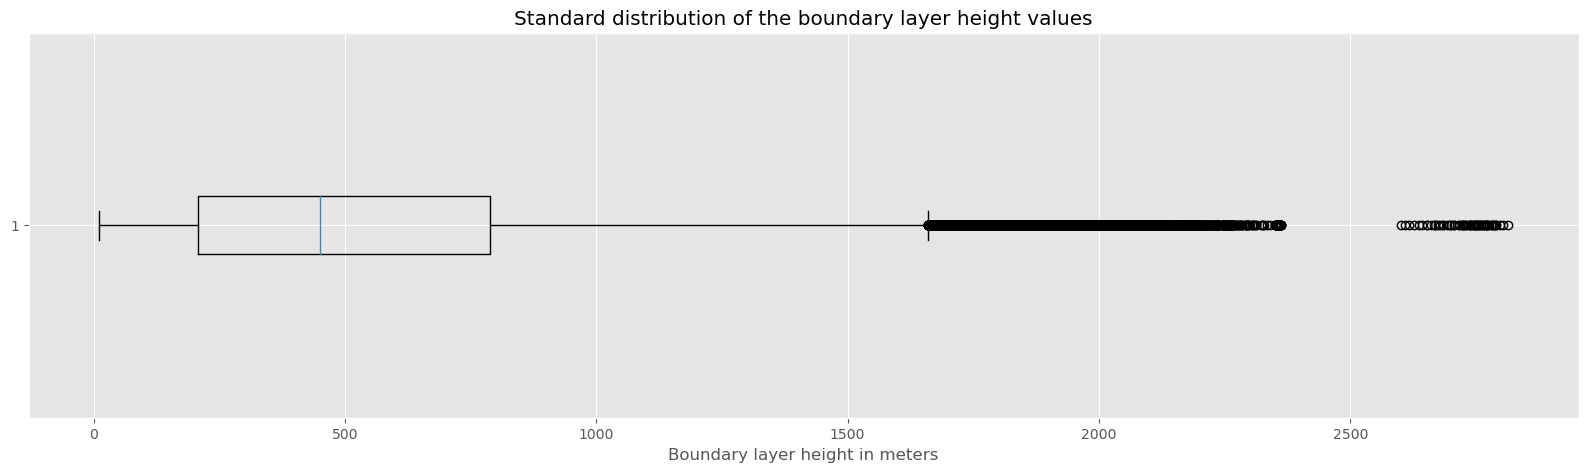

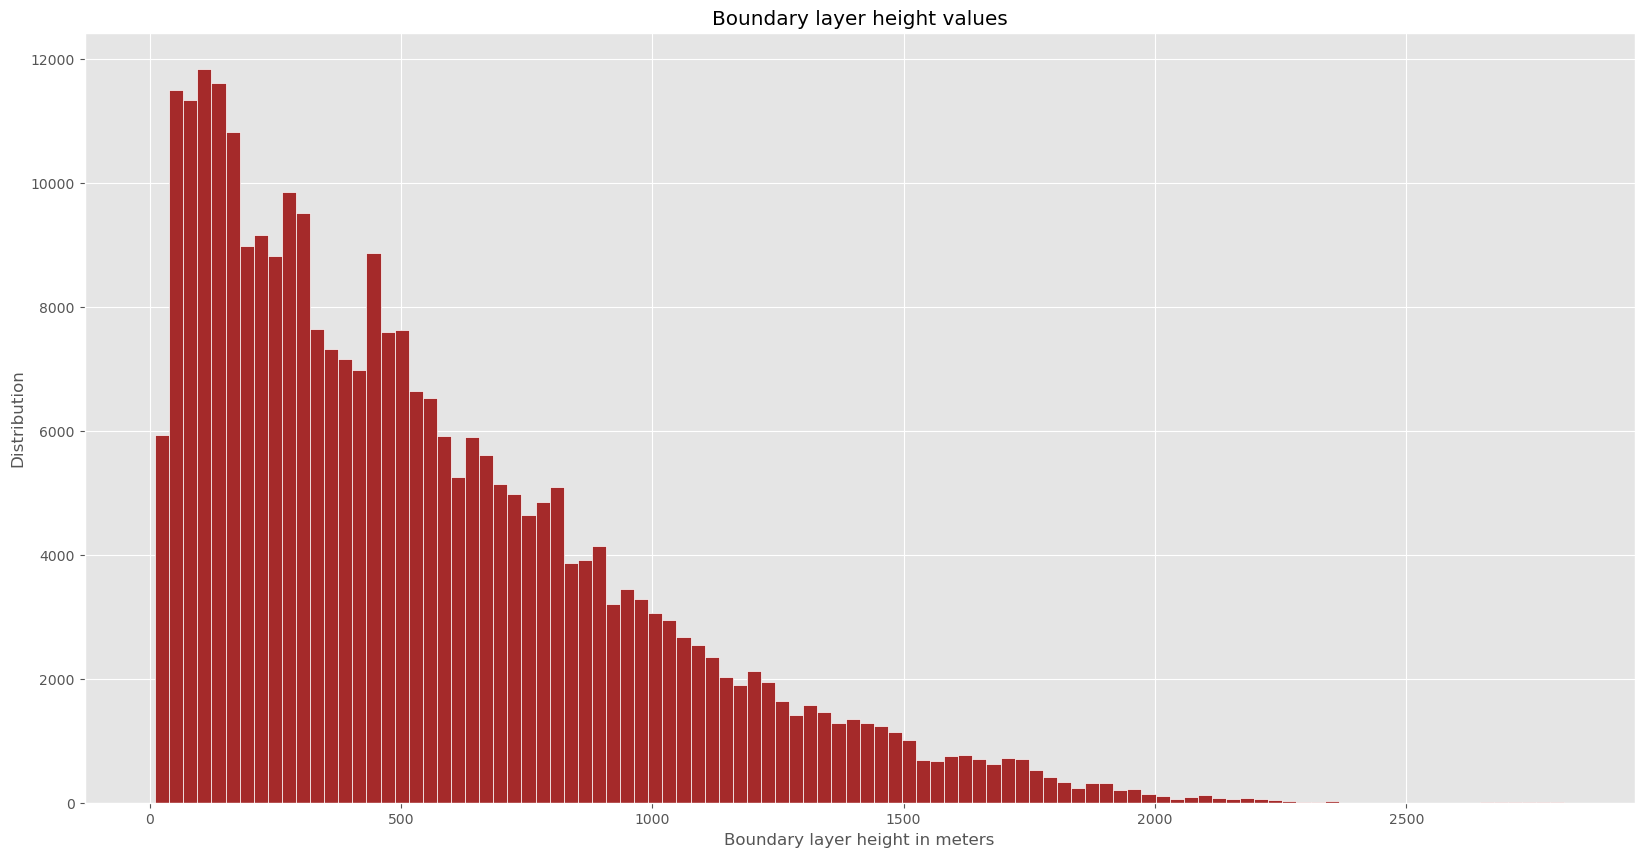

In [ ]:
print("Skewness per column:")
print(df_meteo.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot(df_meteo['blh'], vert=False)
plt.title("Standard distribution of the boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_meteo['blh'], edgecolor='white', color='brown', bins=100)
plt.title("Boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.ylabel("Distribution")
plt.show()

The graphs represent the distribution of the boundary layer height data. The skewness of these graphs are positive. Most of the boundary layer heights are close to zero. You also don't see a lot of outliers on the bottom graph, since the tail of data is not long. This means that the distribution is devided relatively evenly.

<h4><font color=mediumvioletred>Visualize windspeed compared to solar surface radiation downwards</font></h4>

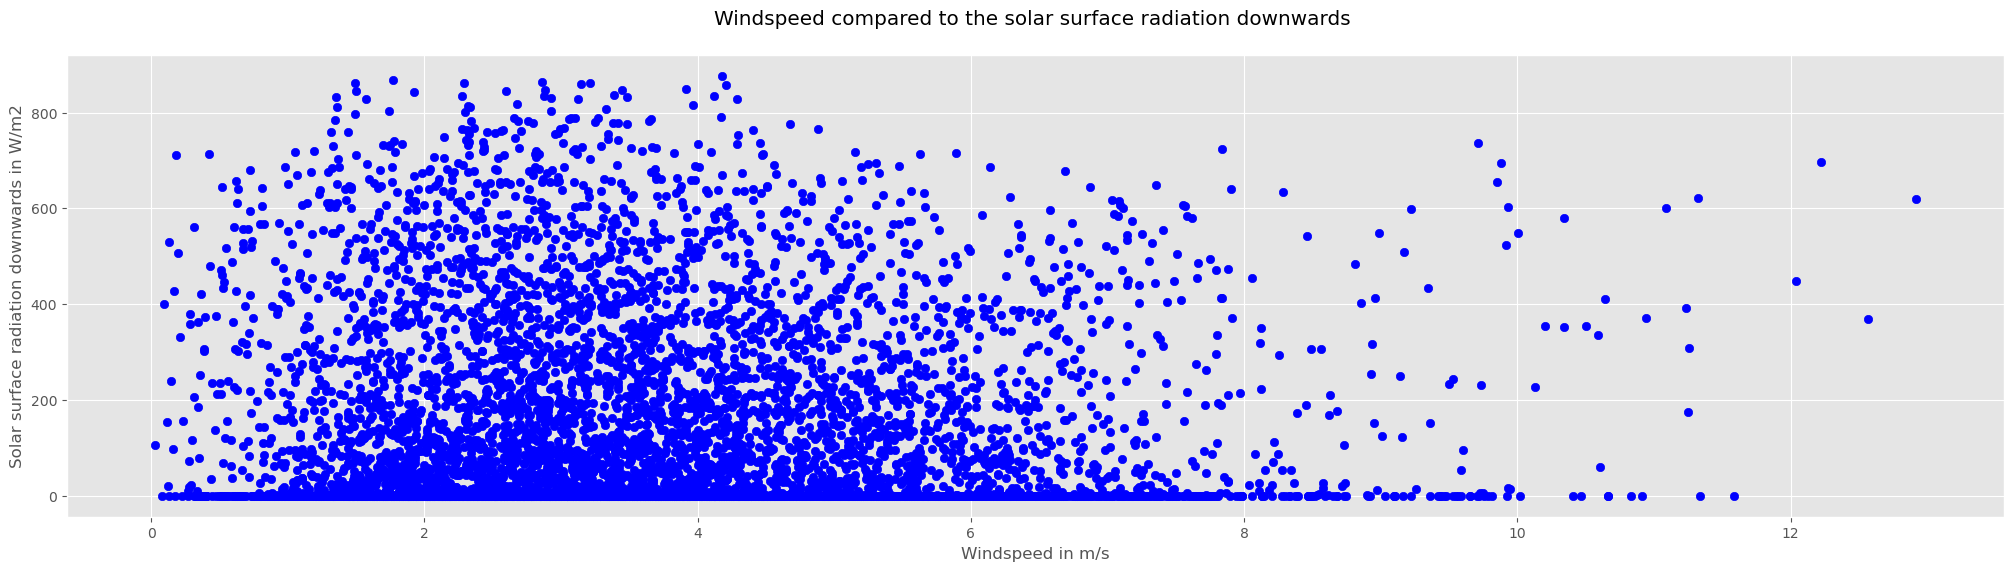

In [ ]:
fig, ax = plt.subplots(figsize=(25, 6))
scatter = ax.scatter((postalcode_df_meteo["ws"]),
                list(postalcode_df_meteo["ssrd"]),
                color="blue")

ax.set(title="Windspeed compared to the solar surface radiation downwards \n",
      xlabel="Windspeed in m/s",
      ylabel="Solar surface radiation downwards in W/m2");

In the graph above you can see that the solar surface rediation downwards (ssrd) almost doesn't appear when the windspeed is above 8m/s. So there is a visable correlation between the windspeed and ssrd. It also shows the 0.000000 values of the ssrd.

<h4><font color=mediumvioletred>Visualize windspeed in September from postal code 5611</font></h4>

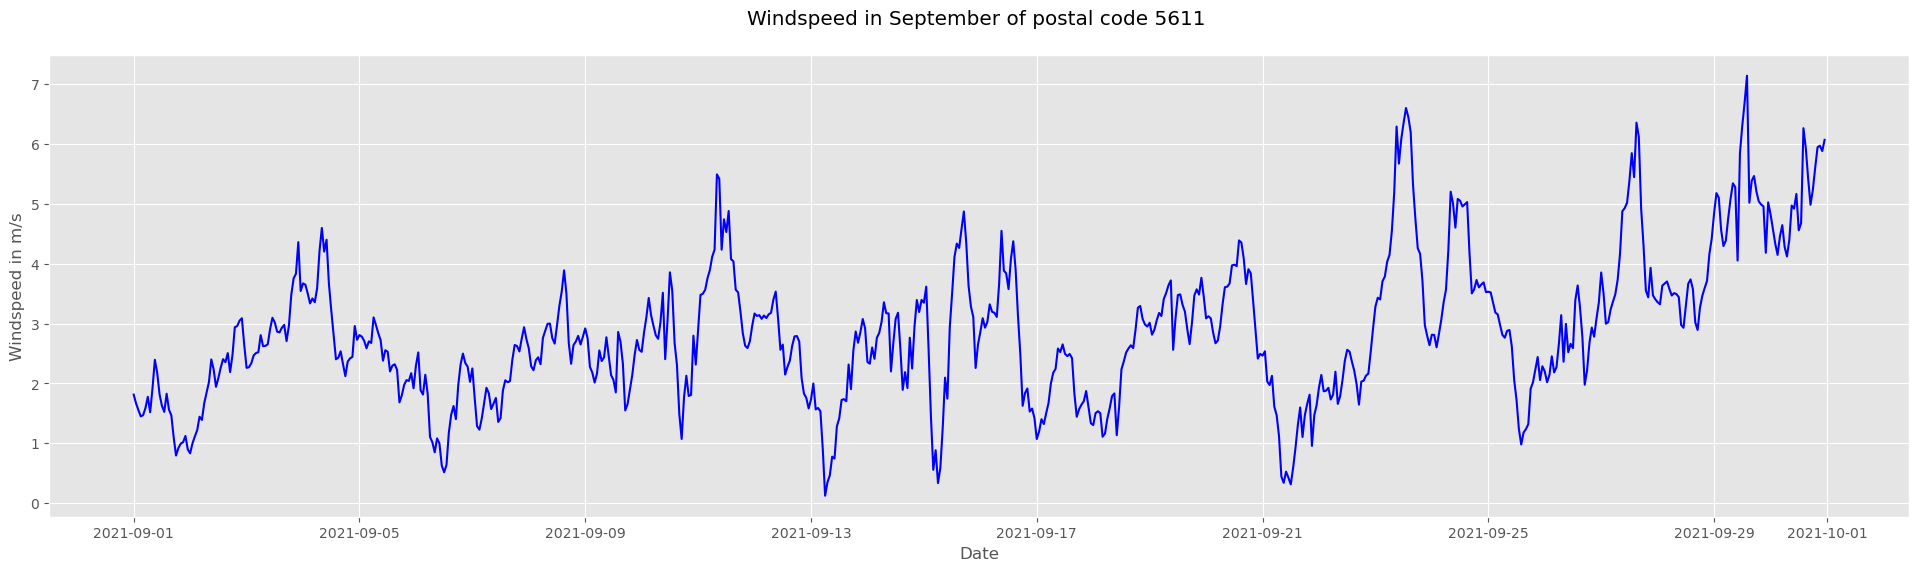

In [ ]:
one_month_postalcode_df_meteo = postalcode_df_meteo[postalcode_df_meteo['date']. dt. strftime('%Y-%m')=='2021-09']

fig, ax = plt.subplots(figsize=(24, 6))
plot = ax.plot(list(one_month_postalcode_df_meteo["date"]),
                list(one_month_postalcode_df_meteo["ws"]),
                color="blue")

ax.set(title="Windspeed in September of postal code 5611 \n",
      xlabel="Date",
      ylabel="Windspeed in m/s");

No real conclusion can be drawn from just looking at the windspeed data. 

<h4><font color=mediumvioletred>Merge meteo and air pollution dataset and show sample</font></h4>

In [ ]:
df_meteo_air_pollution = pd.merge(df_meteo, df_air_pollution[['PC4','date', 'pm10', 'pm2.5', 'no2',	'no', 'so2']], on=['PC4', 'date'])
df_meteo_air_pollution.sample(10)

,date,PC4,wd,ws,blh,tcc,ssrd,pm10,pm2.5,no2,no,so2
62483,2021-12-15 10:00:00,5652,224.379150,4.104749,380.330048,0.997663,43.558815,32.707830,59.000390,26.847754,8.501028,4.640585
23117,2021-12-24 04:00:00,5623,197.685272,5.463914,661.500671,0.998211,0.000000,27.460460,40.214270,20.133174,0.382880,1.776541
66684,2021-11-26 12:00:00,5654,261.051941,5.945234,751.548218,0.998660,153.910017,12.774438,6.899565,15.381135,10.063189,6.885356
18234,2021-12-14 17:00:00,5621,221.417053,3.488743,351.023224,1.000000,0.000000,36.370540,63.355160,37.445784,1.479454,3.301015
43825,2021-12-14 00:00:00,5633,236.653030,3.215179,380.861877,1.000000,0.000000,14.500990,27.117280,9.072731,0.037863,1.749998
2906,2021-10-19 02:00:00,5612,250.846786,4.255532,525.803284,1.000000,0.000000,2.648627,2.381751,8.481910,5.549335,3.169415
51688,2021-10-14 16:00:00,5644,210.938309,4.417283,807.865479,0.737649,69.354240,15.312683,7.176830,12.002629,7.852784,3.971584
10372,2021-11-08 04:00:00,5615,205.806229,2.427080,110.278175,0.533541,0.000000,21.189661,15.351438,14.391862,9.415952,7.607990
69037,2021-11-27 13:00:00,5655,224.281479,4.520030,591.722351,0.911470,117.354505,14.555954,7.971635,11.406873,7.463008,1.984881
10566,2021-11-16 06:00:00,5615,96.112411,1.433392,213.912994,1.000000,0.000000,51.384167,47.442825,32.324606,21.148545,5.807638


<h4><font color=mediumvioletred>Show corrolation between merged meteo and air pollution data</font></h4>

In [ ]:
df_meteo_air_pollution.corr(method='spearman')

C:\Users\rawan\AppData\Local\Temp\ipykernel_41192\329891679.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,PC4,wd,ws,blh,tcc,ssrd,pm10,pm2.5,no2,no,so2
PC4,1.000000,-0.000203,-0.001175,-0.000395,-0.000085,0.000106,-0.026865,-0.028674,-0.034462,-0.027125,0.004346
wd,-0.000203,1.000000,0.190082,0.048322,0.050032,0.032333,-0.148475,-0.106274,-0.161741,-0.109364,-0.008121
ws,-0.001175,0.190082,1.000000,0.807271,0.176822,0.073962,-0.607904,-0.472557,-0.591700,-0.499212,-0.212465
blh,-0.000395,0.048322,0.807271,1.000000,0.200182,0.341155,-0.615602,-0.542800,-0.655762,-0.502562,-0.337730
tcc,-0.000085,0.050032,0.176822,0.200182,1.000000,0.001251,-0.031441,0.110042,-0.105527,-0.186421,-0.208994
ssrd,0.000106,0.032333,0.073962,0.341155,0.001251,1.000000,-0.059004,-0.158170,-0.206825,-0.049303,-0.076840
pm10,-0.026865,-0.148475,-0.607904,-0.615602,-0.031441,-0.059004,1.000000,0.886844,0.560476,0.283385,0.336788
pm2.5,-0.028674,-0.106274,-0.472557,-0.542800,0.110042,-0.158170,0.886844,1.000000,0.431592,0.014917,0.189855
no2,-0.034462,-0.161741,-0.591700,-0.655762,-0.105527,-0.206825,0.560476,0.431592,1.000000,0.735620,0.394545
no,-0.027125,-0.109364,-0.499212,-0.502562,-0.186421,-0.049303,0.283385,0.014917,0.735620,1.000000,0.371746


With the spearman method, it can be noted that the particulate matter smaller than 2.5 micrometer (pm2.5) has the most corrolation with the boundary layer height (blh), the windspeed (ws), and nitrogen dioxide in ug/m3 (no2).

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and windspeed</font></h4>

-0.4220468437258586


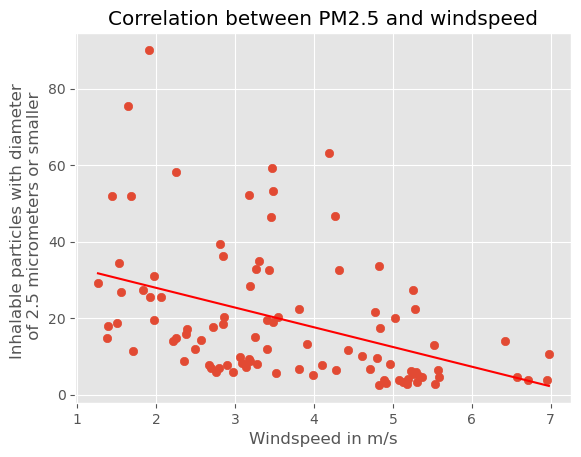

In [ ]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ws"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ws"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ws"]), np.poly1d(np.polyfit(group_by_day["ws"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ws"])), color='red')
plt.title('Correlation between PM2.5 and windspeed')
plt.xlabel('Windspeed in m/s')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the windspeed keep increasing. So there is a low negative correlation between the two. Which means with higher wind speeds there are less particals of 2.5 micrometers or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and boundary layer height</font></h4>

-0.5270951619288825


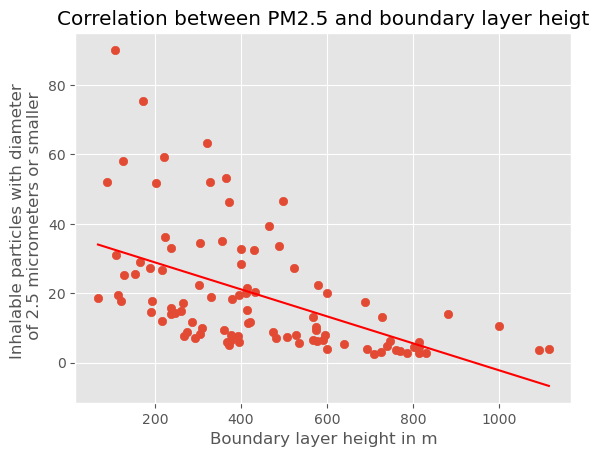

In [ ]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["blh"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["blh"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["blh"]), np.poly1d(np.polyfit(group_by_day["blh"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["blh"])), color='red')
plt.title('Correlation between PM2.5 and boundary layer heigt')
plt.xlabel('Boundary layer height in m')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the boundary layer height keeps increasing. So there is a low negative correlation between the two. Which means that how higher the boundary layer, the less there are particles of 2.5 micrometer or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and solar surface radiation downwards</font></h4>

-0.44465439902953424


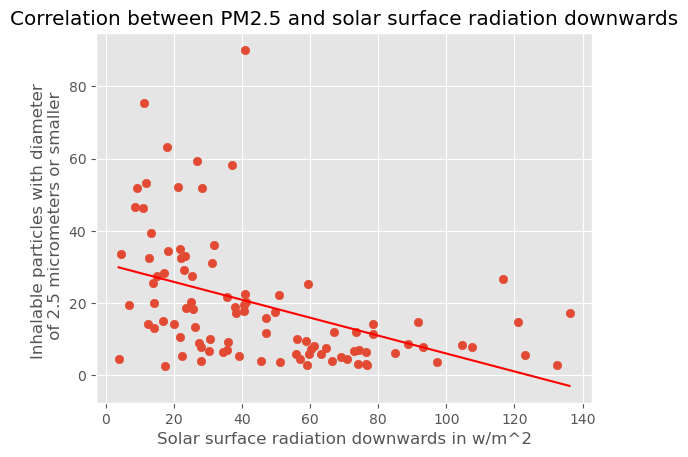

In [ ]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ssrd"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ssrd"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ssrd"]), np.poly1d(np.polyfit(group_by_day["ssrd"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ssrd"])), color='red')
plt.title('Correlation between PM2.5 and solar surface radiation downwards')
plt.xlabel('Solar surface radiation downwards in w/m^2')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the solar surface radiation keep increasing. So there is a low negative correlation between the two. Which means that the higher the solar surface radiation is the less there are particles smaller than 2.5 micrometer in the air.

<h4><font color=mediumvioletred> Visualize the boundary layer height for the first week of November of postal code 5611</font></h4>

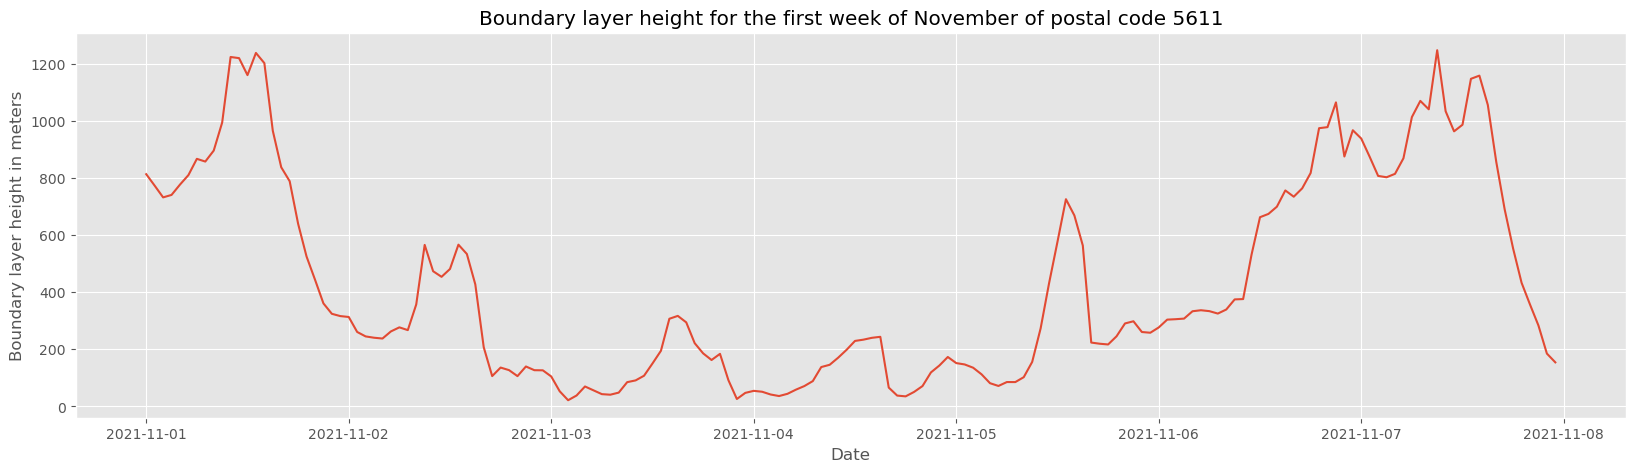

In [ ]:
# Combined meto and air polution data for postalcode 5611
postalcode_df_meteo_air_polution = df_meteo_air_pollution[df_meteo_air_pollution['PC4'] == 5611]

# Combined data for the first week of november 2021 from postal code 5611 (24 * 7 = 168 entries)
one_week_postalcode_df_meteo_air_polution = postalcode_df_meteo_air_polution[postalcode_df_meteo_air_polution['date']. dt. strftime('%Y-%m')=='2021-11'].head(168)
    
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['blh'])
 
# Adding Title to the Plot
plt.title('Boundary layer height for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Boundary layer height in meters')
  
plt.show()

In the graph above you can see that almost every day at around noon the boundary layer height increases and decreases later at night. That is because the surface temperature at noon elevated lead to increased sensitive heat flux, and as a result, the boundary layer height will develop higher during daytime. 

<h4><font color=mediumvioletred> Visualize particulate matter smaller than 2.5 micrometers for the first week of November of postal code 5611</font></h4>

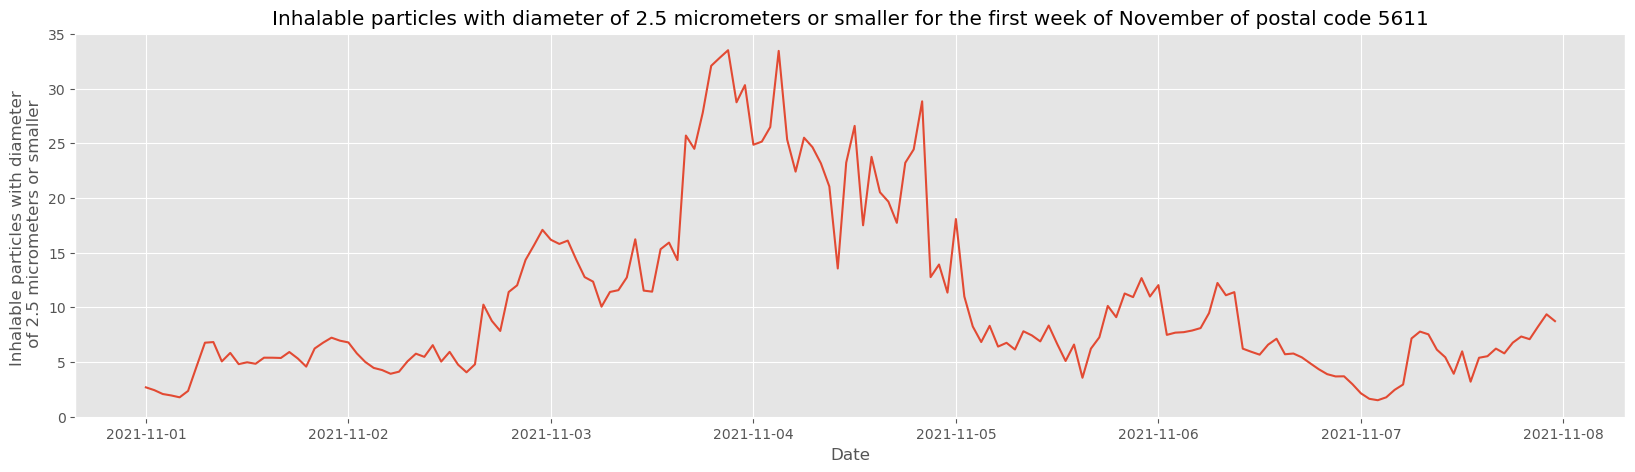

In [ ]:
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['pm2.5'])
 
# Adding Title to the Plot
plt.title('Inhalable particles with diameter of 2.5 micrometers or smaller for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller')
  
plt.show()

In the graph above the particulate matter of 2.5 micrometer or smaller is visualized for the first week of November. You can see that almost every night the particals are lower then during the day. It is hard to see peaks in PM2.5 during the day but you can see a clearly difference between the particals at night and day. 

<h4><font color=mediumvioletred>Conclusion</font></h4>

After exploring and visualising the combined meteo- and pollution data, we came to the conclusion that the boundary layer height, the windspeed, the nitrogen dioxide in ug/m3, and the solar surface radiation downwards had the most corrolation on the PM2.5 values. Since this is the most important measurement of the pollution data, we devided that moving forward we are going to use this data in the air pollution prediction tool.

<h3><font color=steelblue>Air pollution dataset</font></h3>

<h4><font color=mediumvioletred>Read CSV files</font></h4>

In [ ]:
df_ap_np = pd.read_csv('data/air_pollution.csv')
df_ap = pd.read_csv("data/air_pollution.csv", parse_dates=["date"])
df_ap_per_date_per_postalcode = df_ap.groupby([pd.Grouper(freq='D', key='date'),
                     'PC4']).mean()

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..)</font></h4>

In [ ]:
df_ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76824 entries, 0 to 76823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    76824 non-null  datetime64[ns]
 1   PC4     76824 non-null  int64         
 2   pm10    76824 non-null  float64       
 3   pm2.5   76824 non-null  float64       
 4   no2     76824 non-null  float64       
 5   no      76824 non-null  float64       
 6   so2     76824 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 4.1 MB


<h4><font color=mediumvioletred>Get the generate descriptive statistics of the columns</font></h4>

In [ ]:
df_ap.describe()

,PC4,pm10,pm2.5,no2,no,so2
count,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000,76824.000000
mean,5633.818182,19.300461,19.306449,25.810896,14.578421,3.419556
std,15.168756,12.790363,19.325968,13.715641,12.749047,3.060791
min,5611.000000,0.491714,0.419603,1.665652,0.000398,0.000000
25%,5622.000000,9.789488,5.986320,14.671372,4.785573,1.330161
50%,5631.000000,16.246310,12.186803,23.211536,12.002913,2.583675
75%,5646.000000,26.378854,26.603072,35.263642,22.173757,4.383727
max,5658.000000,89.593300,144.709400,79.853535,145.954814,26.323172


<h4><font color=mediumvioletred>Testing for Normality</font></h4>

Skewness per column:
PC4      0.133642
pm10     1.312018
pm2.5    2.101590
no2      0.621710
no       1.845079
so2      2.078176
dtype: float64


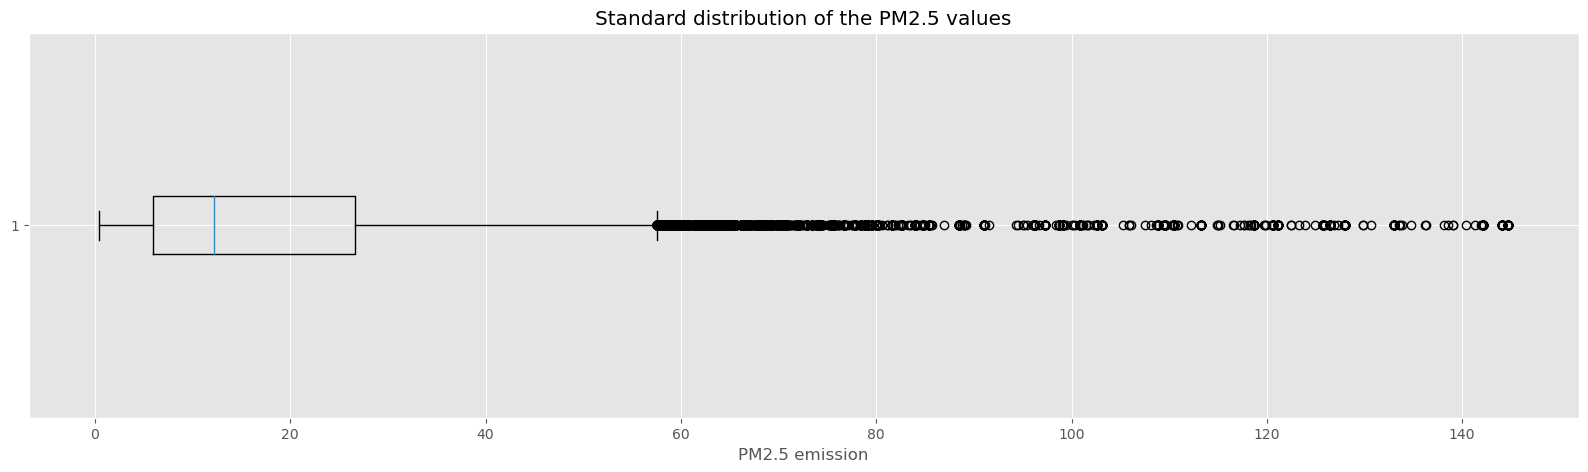

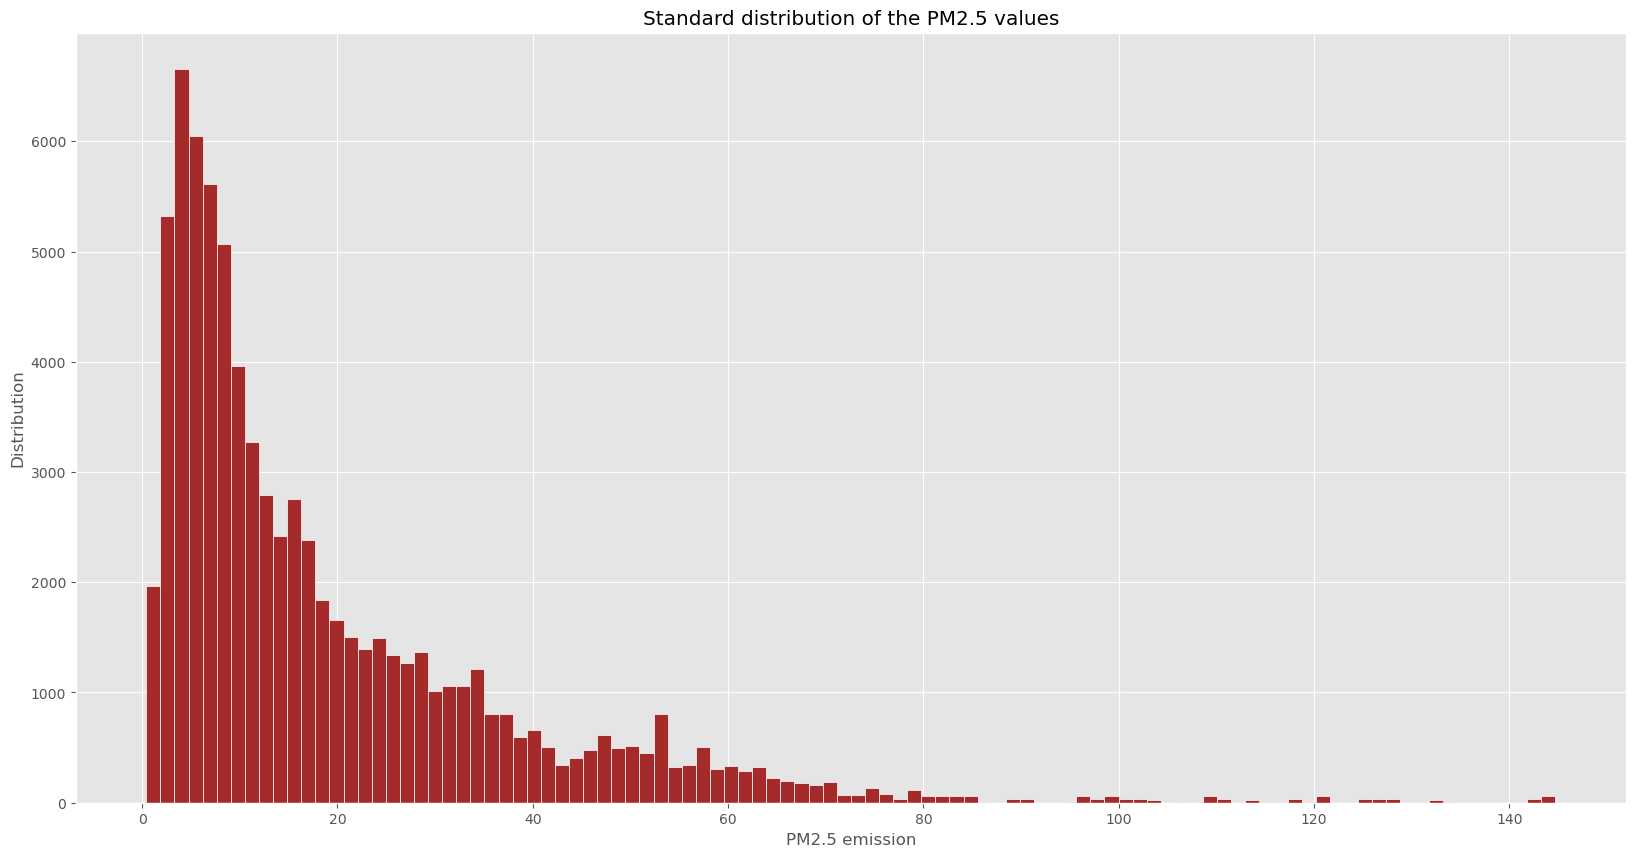

In [ ]:
print("Skewness per column:")
print(df_ap.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot( df_ap['pm2.5'], vert=False)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_ap['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.ylabel("Distribution")
plt.show()

Most skewed data in the dataset is the PM2.5 data.<br>
There is a peak of 144 at the end of the tail. This could imply that anomalies exist in the data.<br>
These number values are unexpectedly high compared to what would be normal.<br> 

These anomalies could cause malfunctions in future model(s). Action could be taken to minimize the effect of these anomalies.

<h4><font color=mediumvioletred>Correlations in the dataset - Correlation matrix</font></h4>

In [ ]:
df_ap.corr(numeric_only=True)

,PC4,pm10,pm2.5,no2,no,so2
PC4,1.000000,-0.022215,-0.015463,-0.032789,-0.024208,-0.000279
pm10,-0.022215,1.000000,0.842424,0.443763,0.419273,0.354938
pm2.5,-0.015463,0.842424,1.000000,0.252095,0.178604,0.162552
no2,-0.032789,0.443763,0.252095,1.000000,0.674611,0.362617
no,-0.024208,0.419273,0.178604,0.674611,1.000000,0.309740
so2,-0.000279,0.354938,0.162552,0.362617,0.309740,1.000000


PM2.5 column is deeply correlated with the PM10 column.

<h4><font color=mediumvioletred>Correlations in the dataset - Testing different correlation functions on PM2.5 column</font></h4>

In [ ]:
print('Pearson: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='pearson')))
print('Spearman: ' + str(df_ap['pm2.5'].corr(df_ap['pm10'], method='spearman')))


Pearson: 0.8424240709438275
Spearman: 0.8868444860412877


The two column excibit a high relationship both linearly and monotonically.

<h4><font color=mediumvioletred>Correlations in the dataset - Plotting the correlation between the PM10 and the PM2.5 columns</font></h4>

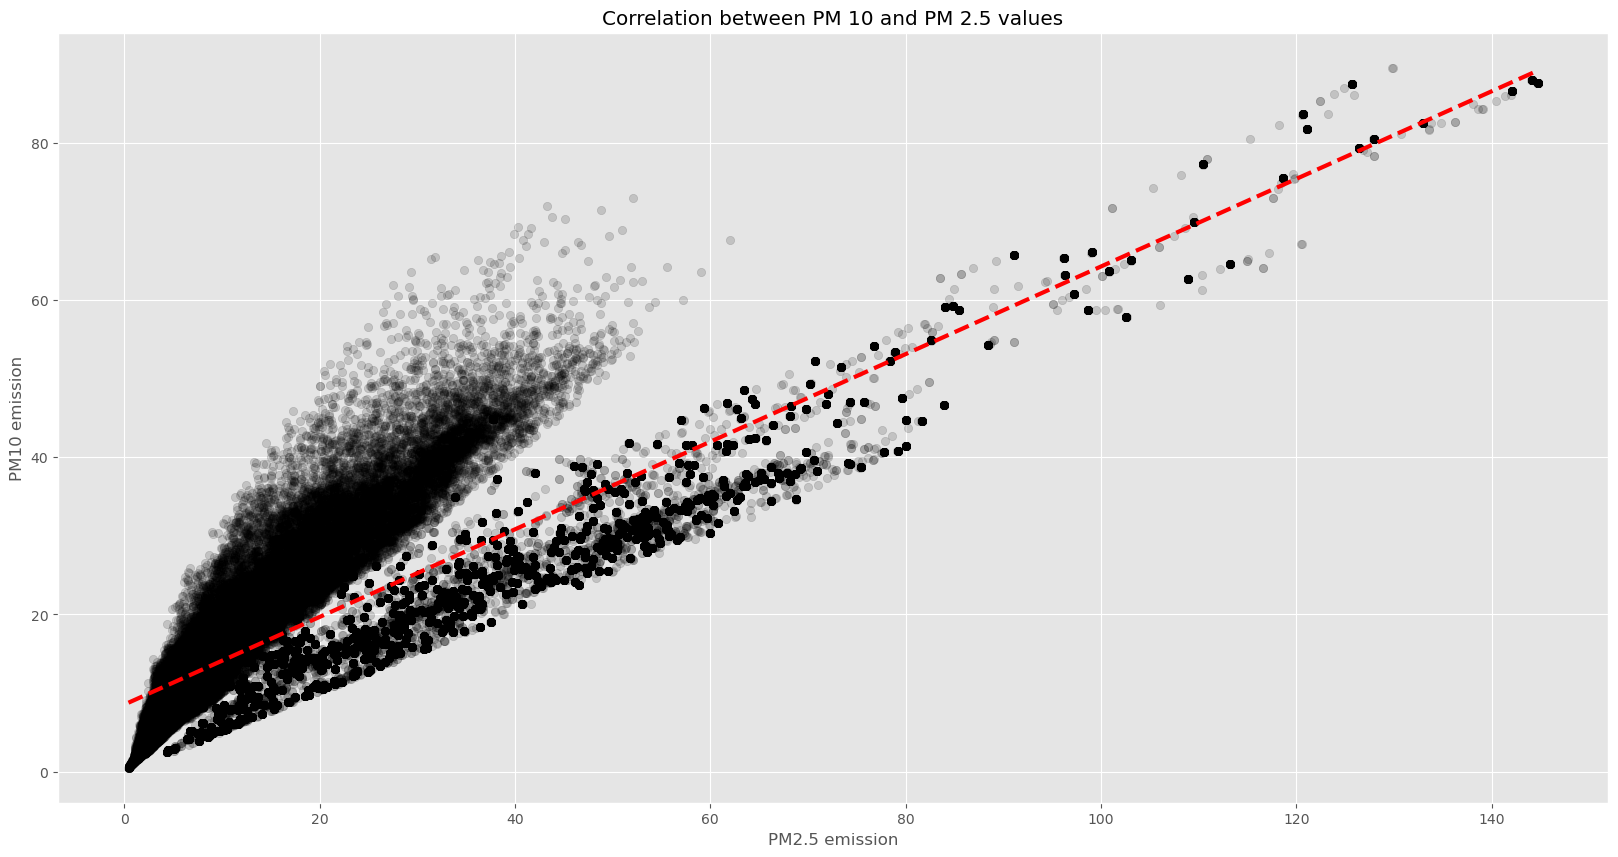

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(df_ap["pm2.5"], df_ap["pm10"], alpha=.15, color='black')
plt.plot(np.unique(df_ap["pm2.5"]), np.poly1d(np.polyfit(df_ap["pm2.5"], df_ap["pm10"], 1))
         (np.unique(df_ap["pm2.5"])), color='red', linewidth=3, linestyle='dashed')
plt.xlabel('PM2.5 emission')
plt.ylabel('PM10 emission')
plt.title("Correlation between PM 10 and PM 2.5 values")
plt.show()

PM2.5 emission is deeply correlated with the PM10 emission.

<h4><font color=mediumvioletred>PM2.5 values - Daily average(mean) </font></h4>

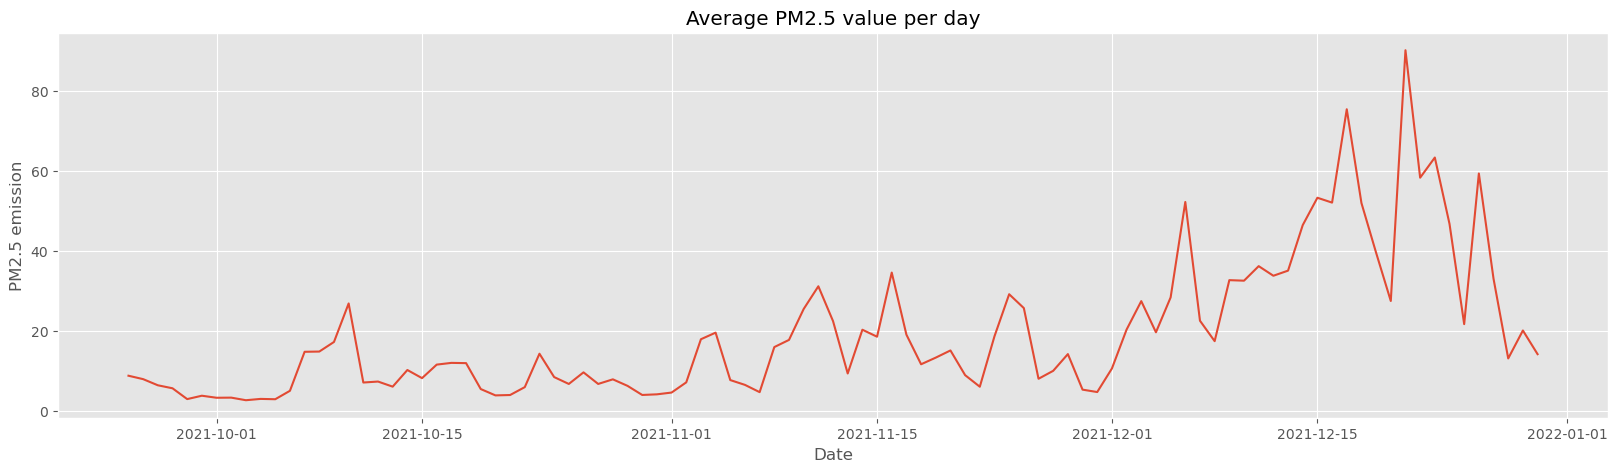

In [ ]:
df_ap_day_mean = df_ap.groupby(pd.Grouper(freq='D', key='date')).mean()
plt.figure(figsize=(20,5))
plt.title("Average PM2.5 value per day")
plt.plot(df_ap_day_mean['pm2.5'])
plt.xlabel("Date")
plt.ylabel("PM2.5 emission")
plt.show()

The daily PM2.5 pollution is very high during the Holiday season. 

<h4><font color=mediumvioletred> Worst mean total pollution in different postal code areas</font></h4>

In [ ]:
df_ap_sp = df_ap.groupby(['PC4']).mean(numeric_only=True)
print('Most populated areas with the pollution type:')
df_ap_sp = df_ap_sp.drop_duplicates()
df_ap_sp.reset_index().style.highlight_max(color = 'orange')

Most populated areas with the pollution type:


,PC4,pm10,pm2.5,no2,no,so2
0,5611,19.984079,19.960272,26.572523,15.087846,3.490208
1,5612,19.963204,19.884173,26.624472,15.121834,3.475344
2,5613,19.471481,19.590238,26.040624,14.739848,3.420596
3,5614,19.324781,19.479003,25.688555,14.509505,3.404681
4,5615,19.718299,19.725237,25.956133,14.684570,3.465811
5,5616,20.062076,20.000029,26.235977,14.867659,3.507084
6,5617,20.190379,20.063174,26.374419,14.958236,3.504149
7,5621,19.835366,19.854896,26.110725,14.785713,3.432458
8,5622,19.865506,19.830804,26.289081,14.902403,3.430030
9,5623,20.074333,19.975982,26.695390,15.168232,3.453108


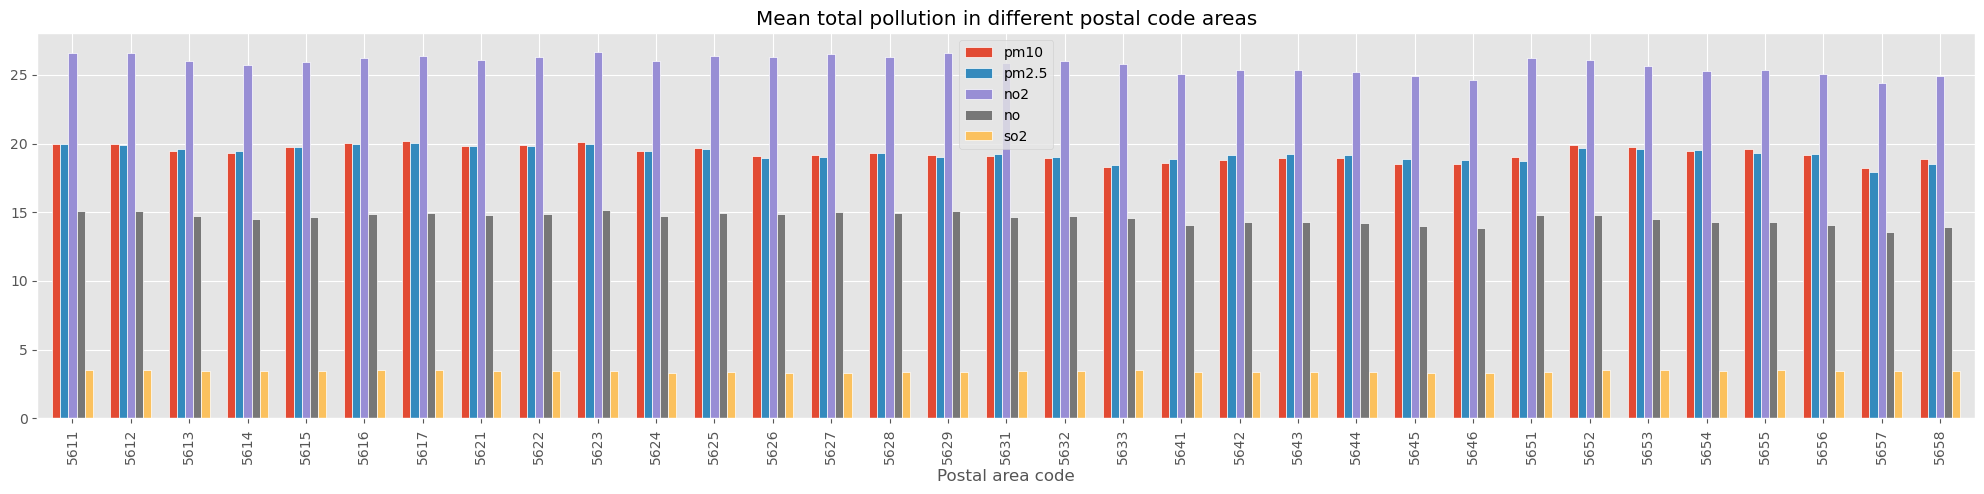

In [ ]:
plot = df_ap_sp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Mean total pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

<h4><font color=mediumvioletred> Most peak pollution in different postal code areas</font></h4>

In [ ]:
df_ap_mp = df_ap.groupby(['PC4']).max(numeric_only=True)
print('Most polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_mp.idxmax())
df_ap_mp = df_ap_mp.drop_duplicates()
df_ap_mp.reset_index().style.highlight_max(color = 'orange')

Most polluted areas per pollution type:
pm10     5658
pm2.5    5611
no2      5658
no       5658
so2      5625
dtype: int64


,PC4,pm10,pm2.5,no2,no,so2
0,5611,88.080540,144.709400,71.381888,121.946628,23.344864
1,5612,88.080540,144.709400,71.274923,121.946628,25.220871
2,5613,88.080530,144.709400,69.206424,121.946628,23.386072
3,5614,88.080530,144.709400,68.357741,121.946628,20.949102
4,5615,88.080530,144.709400,71.718876,121.946628,21.319842
5,5616,88.080530,144.709400,75.743100,121.946628,24.085637
6,5617,88.080540,144.709400,76.095894,121.946628,25.071658
7,5621,88.080540,144.709400,73.775033,121.946628,26.241260
8,5622,88.080540,144.709400,72.820876,121.946628,26.130241
9,5623,88.080530,144.709400,71.342982,121.946628,26.261284


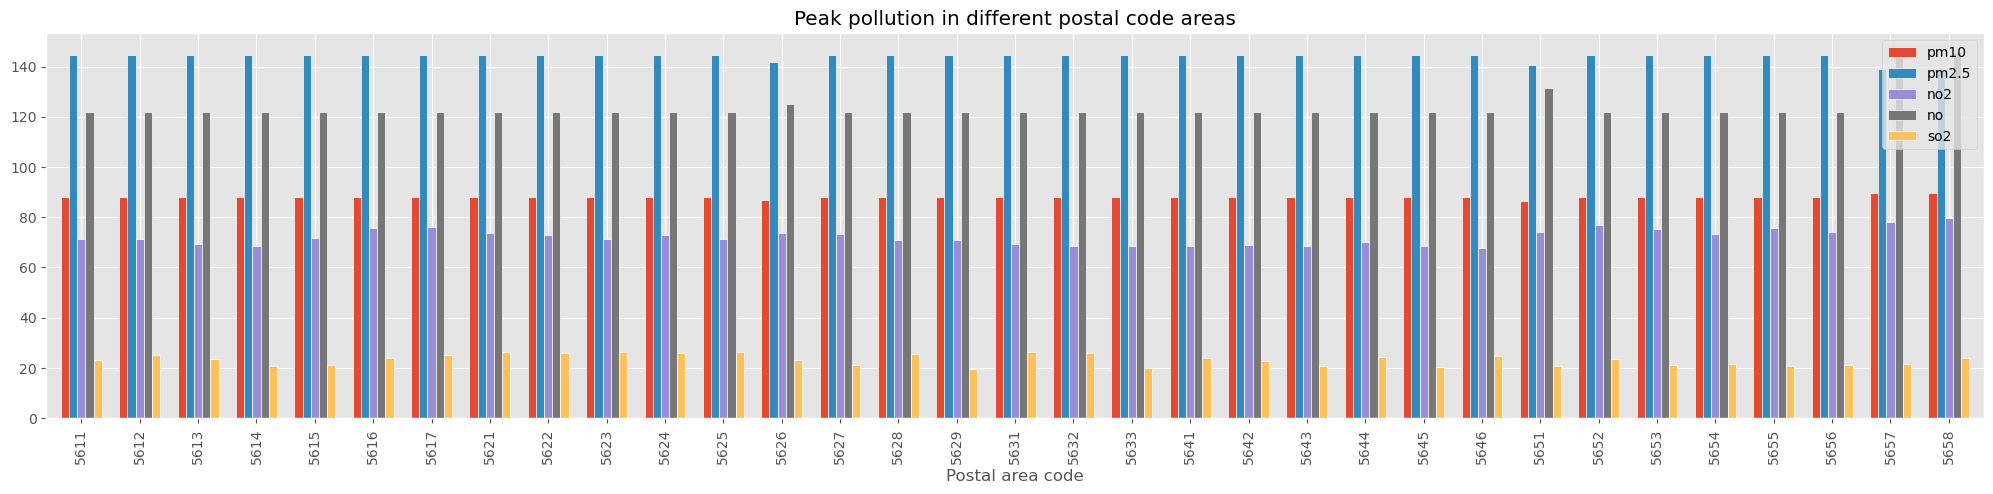

In [ ]:
plot = df_ap_mp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Peak pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

There are several instances of the PM2.5 pollution with the value of 144.709400.<br>
The PM2.5 sensor might be peaking, therefore, the taken measurement might be incorrect.

<h4><font color=mediumvioletred> Least pollution in different postal code areas</font></h4>

In [ ]:
df_ap_lp = df_ap.groupby(['PC4']).min(numeric_only=True)

print('Least polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_lp.idxmin())

df_ap_lp = df_ap_lp.drop_duplicates()
df_ap_lp.reset_index().style.highlight_min(color = 'lightgreen')

Least polluted areas per pollution type:
pm10     5644
pm2.5    5644
no2      5646
no       5611
so2      5658
dtype: int64


,PC4,pm10,pm2.5,no2,no,so2
0,5611,0.530789,0.451635,2.392360,0.000398,0.000000
1,5612,0.578179,0.473515,2.544250,0.000398,0.000000
2,5613,0.520031,0.439185,2.219685,0.000398,0.000000
3,5614,0.498157,0.427967,1.988143,0.000398,0.000000
4,5615,0.501704,0.430377,2.091708,0.000398,0.000000
5,5616,0.700163,0.534429,2.404782,0.000398,0.000000
6,5617,0.814963,0.579557,2.532816,0.000398,0.000000
7,5621,0.876251,0.615081,2.593142,0.000398,0.000000
8,5622,0.777373,0.573218,2.641720,0.000398,0.000000
9,5623,0.626090,0.506606,2.755169,0.000398,0.000000


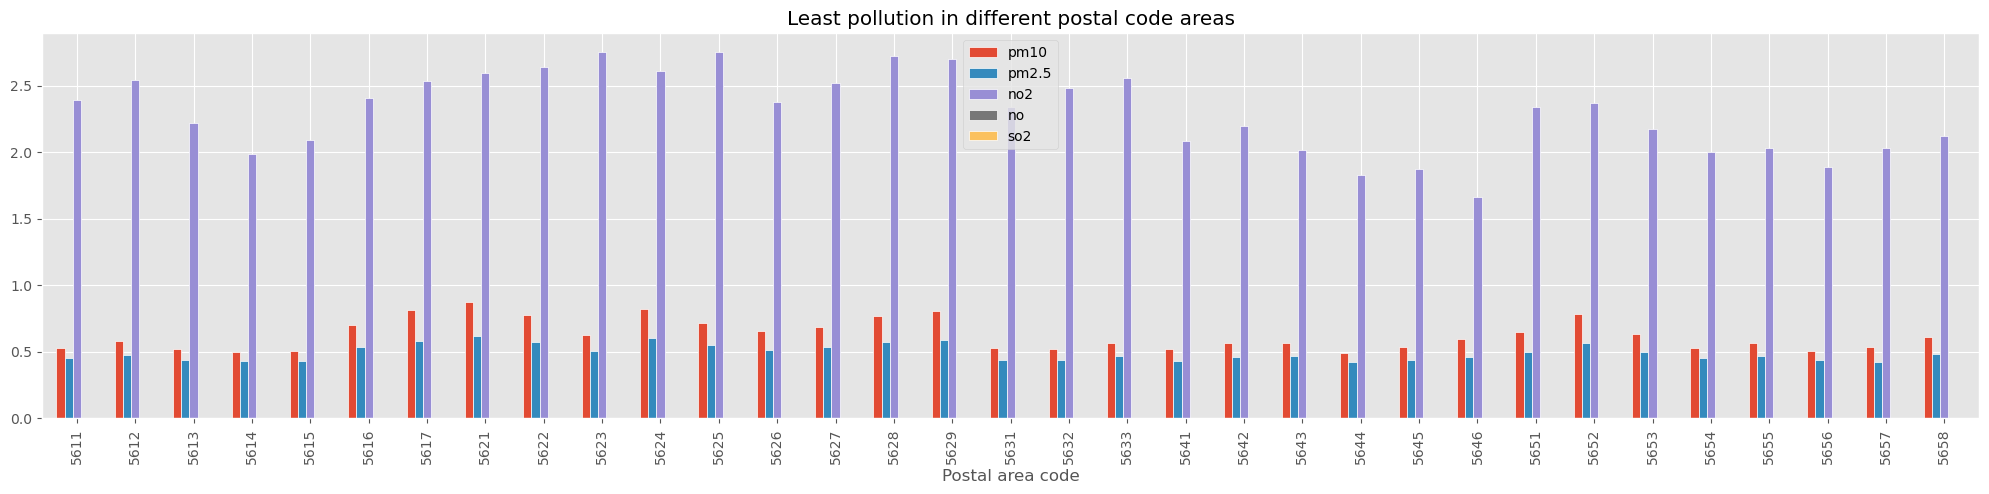

In [ ]:
plot = df_ap_lp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Least pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

The sulfur dioxide sensor is not always taking measurements.


<h4><font color=mediumvioletred>Comparing the most polluted postal code area (day mean) based on the pollution type with the same area on an average day</font></h4>

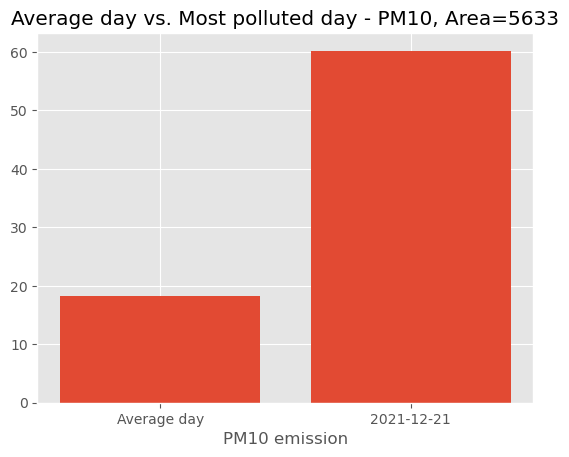

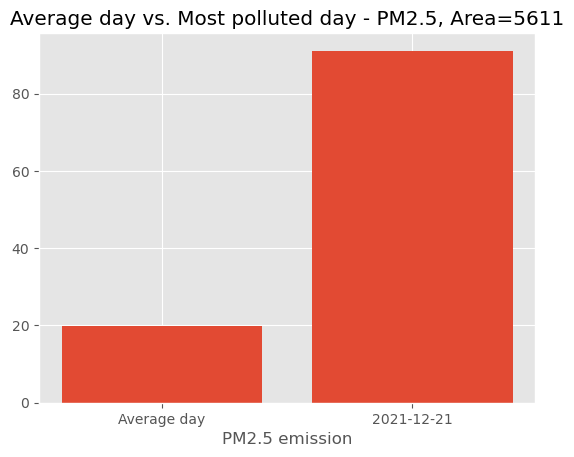

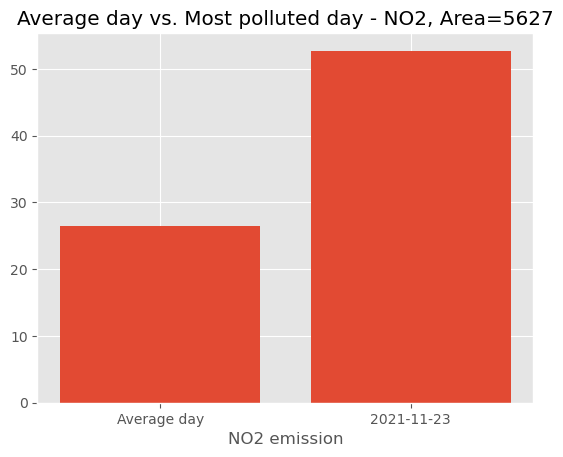

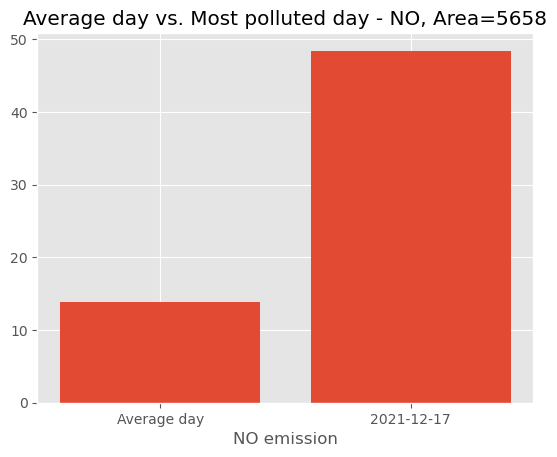

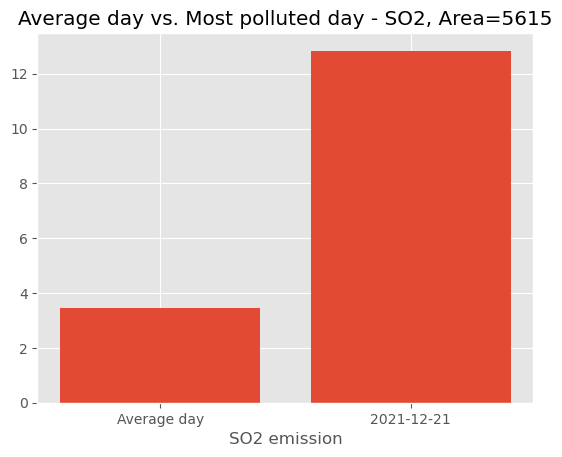

In [ ]:
most_polluted_days = df_ap_per_date_per_postalcode.idxmax()

i = 0
for day in most_polluted_days:
    most_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[most_polluted_days.index[i]], most_polluted_values.loc[most_polluted_days.index[i]]])
    plt.title("Average day vs. Most polluted day - " + str(most_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(most_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

<h4><font color=mediumvioletred>Comparing the least polluted postal code area (day mean) based on the pollution type with the same area on an average day</font></h4>

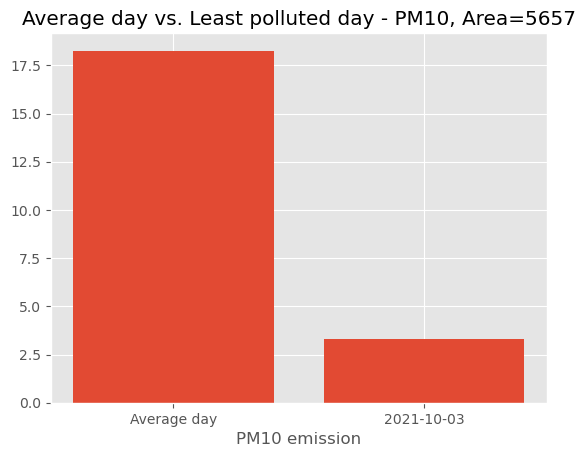

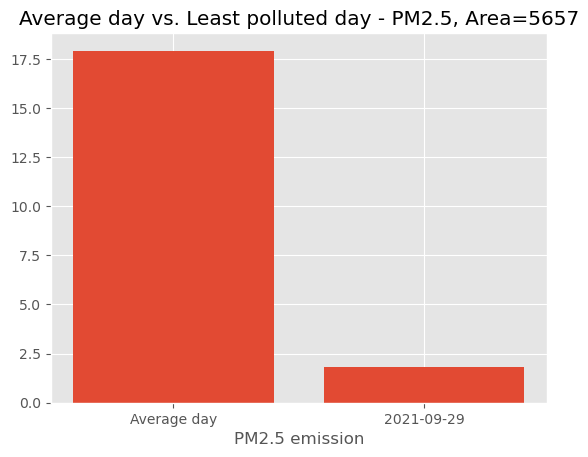

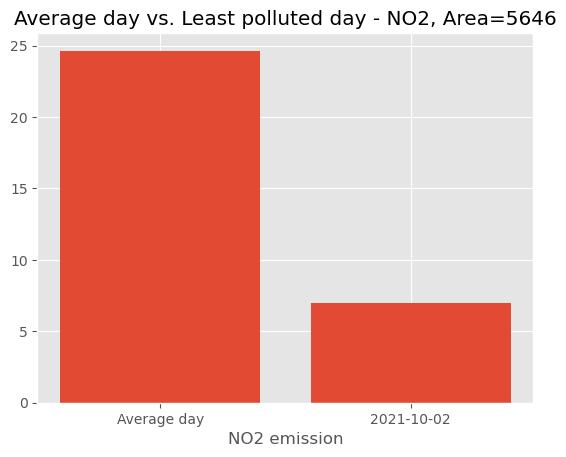

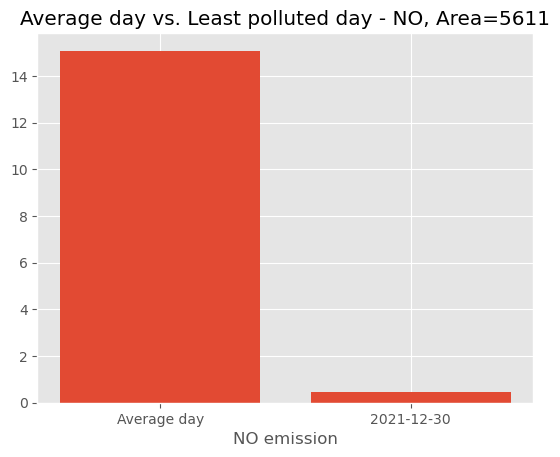

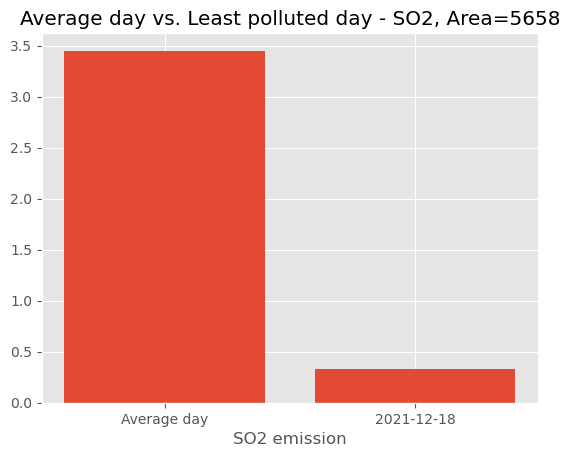

In [ ]:
least_polluted_days = df_ap_per_date_per_postalcode.idxmin()

i = 0
for day in least_polluted_days:
    least_polluted_values = df_ap_per_date_per_postalcode.loc[(day[0] ,day[1]), :]
    all_for_postcode =  df_ap_per_date_per_postalcode.loc[(slice(None), day[1]), :]
    plt.bar(["Average day", str(day[0].date())], [all_for_postcode.mean()[least_polluted_days.index[i]], least_polluted_values.loc[least_polluted_days.index[i]]])
    plt.title("Average day vs. Least polluted day - " + str(least_polluted_days.index[i]).upper() + ", Area=" + str(day[1]) )
    plt.xlabel(str(least_polluted_days.index[i]).upper() + " emission")
    plt.show()
    i += 1

<h4><font color=mediumvioletred>A deeper look at the most polluted day in the most polluted area - PM2.5</font></h4>

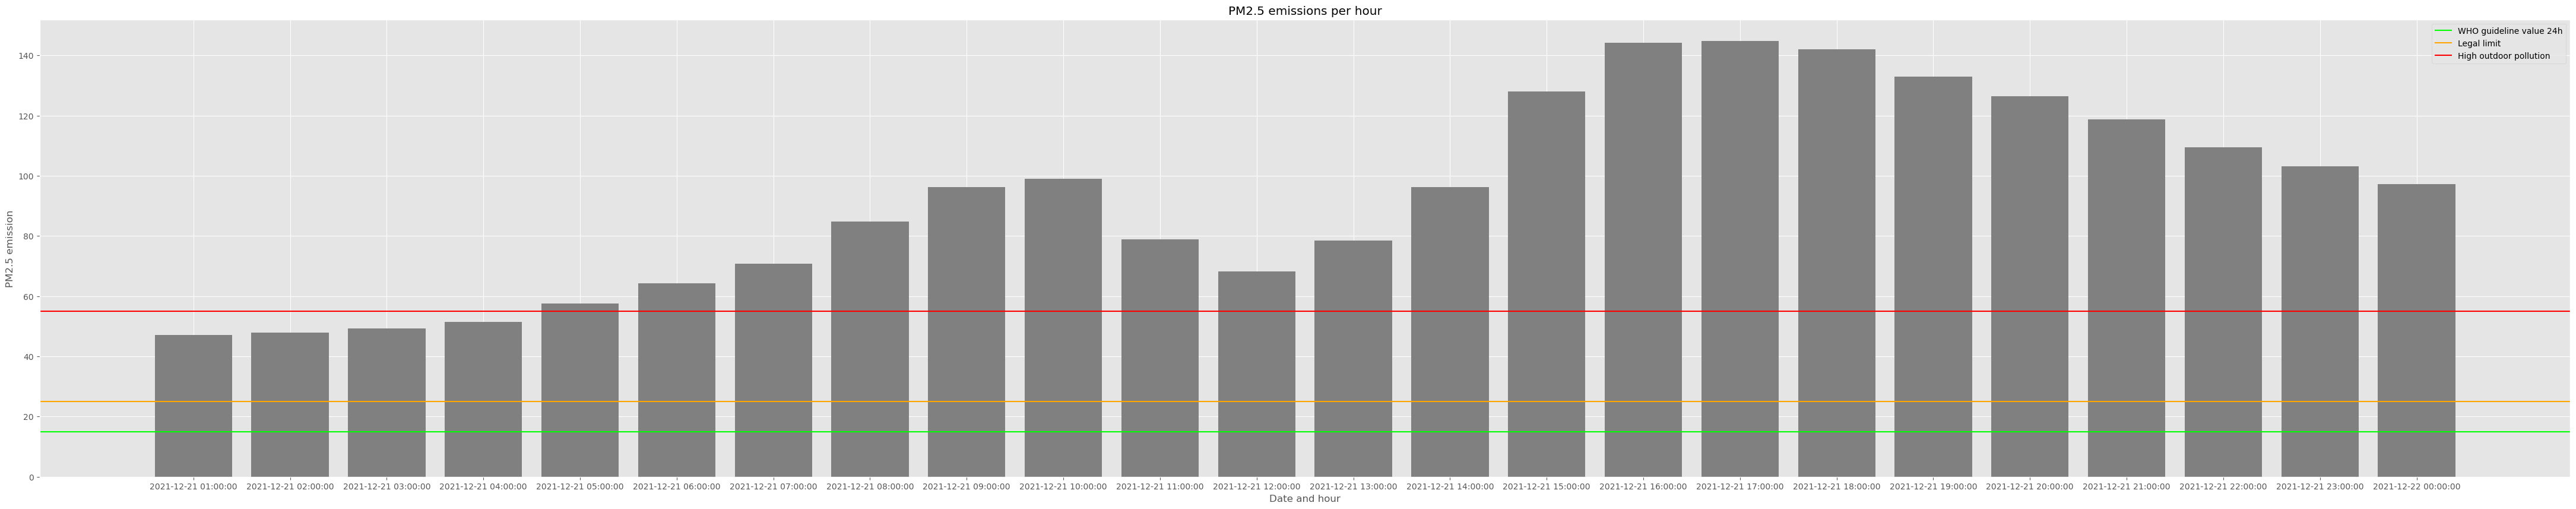

In [ ]:
# DOUBLE CLICK ON THE GRAPH TO ZOOM IN #

most_polluted = df_ap_per_date_per_postalcode.idxmax()['pm2.5']
most_polluted_date = most_polluted[0].date() 
most_polluted_areacode = most_polluted[1]

START_DATE =  str(most_polluted_date + timedelta(days=-0))
END_DATE = str(most_polluted_date + timedelta(days=+1))

FIG_HEIGHT = 10
FIG_WIDTH = 55

mask = ((df_ap['date'] > START_DATE) & (df_ap['date'] <= END_DATE) & (df_ap['PC4'] <= most_polluted_areacode))
air_pollution = df_ap_np.loc[mask]

f = plt.figure()
f.set_figheight(FIG_HEIGHT)
f.set_figwidth(FIG_WIDTH)
plt.bar(air_pollution['date'], air_pollution['pm2.5'], color='gray')
plt.title("PM2.5 emissions per hour")
plt.xlabel("Date and hour")
plt.ylabel("PM2.5 emission")

healthy_level = [15]
legal_limit = [25]
unhealthy_level = [55]

plt.axhline(y = healthy_level, color = '#00FF00', linestyle = '-')
plt.axhline(y = legal_limit, color = '#FFA500', linestyle = '-')
plt.axhline(y = unhealthy_level, color = '#FF0000', linestyle = '-')
plt.legend(['WHO guideline value 24h', 'Legal limit', 'High outdoor pollution '])
plt.show()

The PM2.5 emission on the 21st of December 2021 for the postal code 5611 exceeds the daily Dutch legal limit for air pollution.<br>
However, the project group could not find a precise cause for the excessively high pollution.<br>
The project group speculates that it is caused by people travelling for Christmas related activities.<br> 

Sources for the limits <br>
Safe Limit: https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health<br>
Legal limit: https://www.indoorairhygiene.org/pm2-5-explained/ <br>
Unhealthy limit: https://smartairfilters.com/en/blog/difference-pm2-5-aqi-measurements/<br>

<h4><font color=mediumvioletred>The average emission for each selected postal code on selected days</font></h4>

In [ ]:
df_heat = df_ap_np
# START_DATE =  '2021-09-25'
# END_DATE = '2021-12-31'
# PCODES = [5611, 5626, 5644, 5654, 5658]

# Select rows between start and end date for each postal code
# mask = ((df_heat['date'] > START_DATE) & (df_heat['date'] <= END_DATE))
# df_heat = df_heat.loc[mask]
# df_heat = df_heat.loc[df_heat['PC4'].isin(PCODES)]

# Group by postal code and group by day
df_heat['date'] = pd.to_datetime(df_heat['date'], format='%Y/%m/%d %H:%M:%S')
gr_by_pc4_day = df_heat.groupby(['PC4', df_heat['date'].dt.date]).mean()
print(gr_by_pc4_day)

                      pm10      pm2.5        no2         no       so2
PC4  date                                                            
5611 2021-09-25  16.089859   9.163063  27.160785  17.770088  2.539185
     2021-09-26  17.376689   8.106905  22.998390  15.046819  3.112883
     2021-09-27  11.256416   6.647947  15.691083  10.265974  2.075364
     2021-09-28  11.465175   5.887269  19.930236  13.039463  4.820231
     2021-09-29   6.452490   3.480847  20.465527  13.389680  2.821472
...                    ...        ...        ...        ...       ...
5658 2021-12-26  34.075700  59.589269  32.221544   2.907209  5.245878
     2021-12-27  17.820076  30.528690  21.651155   3.583641  1.487095
     2021-12-28   8.948837  12.570214  16.046669   2.498485  1.538497
     2021-12-29  14.963136  19.360596  20.753625  11.117488  2.826996
     2021-12-30  12.269858  12.880553  12.753498   0.475372  1.749335

[3201 rows x 5 columns]


C:\Users\rawan\AppData\Local\Temp\ipykernel_41192\1328095555.py:13: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<h4><font color=mediumvioletred>Heatmap of the average emission for each selected postal code on selected days</font></h4>

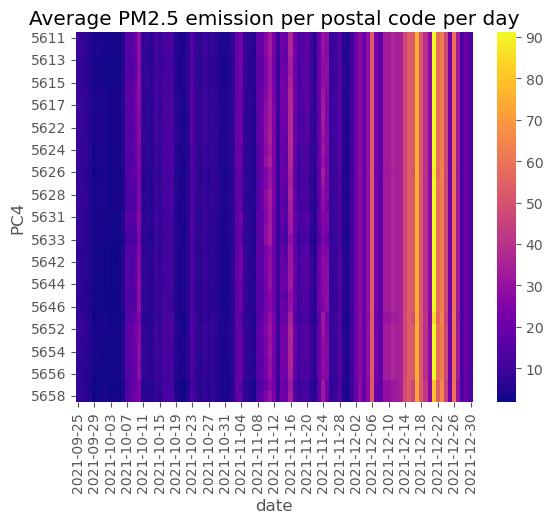

In [ ]:
# Pivot the dataframe from long to wide form
heat = pd.pivot_table(gr_by_pc4_day, index='PC4', columns='date', values='pm2.5')

ax = plt.axes()
sns.heatmap(heat, annot=False, cmap='plasma', ax = ax)
ax.set_title('Average PM2.5 emission per postal code per day')
plt.show()



There is a limited difference in air pollution between different postal codes in Eindhoven.<br>
The emission of air pollutants for the city of Eindhoven is higher in December in comparison to the previous months in the dataset.


<h4><font color=mediumvioletred>Conclusion</font></h4>

The emission of air pollutants is higher during the Holiday season. 
Furthermore, there is little difference of the emission of air pollutants between postal codes in Eindhoven.
Anomalies exist in the dataset, which could lead to the malfunctioning of future model(s) based on this dataset.
Steps should be taken to minimize the risk associated with these anomalies. 

<h2><font color=slateblue> 5. Data Preparation </font></h2>

To prepare the data for the modelling process, the following steps must be taken:
1. Combine the three tables.
2. Calculate number of people per hour, for each row count (m00_30 + m30_60).
3. Separate date and time.
4. Group areas and days.
5. Calculate number of people per day, average per day for pm2.5, wind speed, sun radiation, boundary layer height.
6. Drop rows where there is no pm2.5.
7. Remove/handle outliers in pm2.5.
 
The needed columns for modelling are: date, zipcode, average pm2.5, number of people, wind speed, sun radiation, boundary layer height.

<h4><font color=mediumvioletred>Read the three datasets</font></h4>

In [17]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

# read meteo dataset csv file
df_meteo = pd.read_csv("data/meteo.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets</font></h4>

In [18]:
df_merged = pd.merge(df_zichtop[["PC4", "date", "m00_30", "m30_60"]], 
                     df_air_pollution[["PC4","date", "pm2.5"]], 
                     on=["PC4", "date"])

<h4><font color=mediumvioletred>Merge the previous result with meteo dataset</font></h4>

In [19]:
df_merged = pd.merge(df_merged[["PC4", "date", "m00_30", "m30_60", "pm2.5"]], 
                     df_meteo[["PC4","date", "ws", "ssrd", "blh"]], 
                     on=["PC4", "date"])

<h4><font color=mediumvioletred>Get a sample of the merged datasets</font></h4>

In [20]:
df_merged.sample(5)

,PC4,date,m00_30,m30_60,pm2.5,ws,ssrd,blh
27027,5642,2021-10-21 03:00:00,22.0,0.0,0.677144,9.737385,0.000000,1513.157349
9587,5621,2021-10-09 11:00:00,791.0,68.0,9.571529,2.297684,477.780208,437.128754
30352,5644,2021-11-18 16:00:00,640.0,78.0,8.479602,4.910785,7.969327,578.996460
34650,5652,2021-10-08 18:00:00,879.0,80.0,13.256909,2.576376,0.000000,121.441551
41805,5657,2021-10-31 21:00:00,326.0,61.0,2.692332,4.321141,0.000000,898.260742


<h4><font color=mediumvioletred>Calculate number of people per hour</font></h4>

In [21]:
df_merged["people_number"] = df_merged["m00_30"] + df_merged["m30_60"]
df_merged.sample(5)

,PC4,date,m00_30,m30_60,pm2.5,ws,ssrd,blh,people_number
11762,5622,2021-11-14 02:00:00,18.0,0.0,20.998646,1.838395,0.0,123.204605,18.0
26642,5642,2021-10-05 02:00:00,0.0,0.0,1.411890,5.290466,0.0,485.187195,0.0
13655,5624,2021-10-13 23:00:00,18.0,0.0,8.145866,3.787886,0.0,284.469849,18.0
8015,5617,2021-09-28 23:00:00,0.0,0.0,6.384094,4.468130,0.0,463.825378,0.0
3843,5613,2021-11-14 03:00:00,8.0,24.0,20.425964,2.120785,0.0,166.938644,32.0


<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [22]:
df_merged.rename(columns={"date": "date_time"}, inplace=True)

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [23]:
df_merged["date"] = df_merged["date_time"].dt.date.astype(str)
df_merged["time"] = df_merged["date_time"].dt.time.astype(str)

<h4><font color=mediumvioletred>Drop unneeded columns</font></h4>

In [13]:
df_merged.drop(["m00_30", "m30_60", "date_time"], axis=1, inplace=True)

<h4><font color=mediumvioletred>Get a sample of the merged datasets</font></h4>

In [24]:
df_merged.sample(5)

,PC4,date_time,m00_30,m30_60,pm2.5,ws,ssrd,blh,people_number,date,time
2880,5613,2021-10-05 00:00:00,20.0,0.0,2.373676,4.874819,0.000000,511.416046,20.0,2021-10-05,00:00:00
14432,5624,2021-11-15 08:00:00,164.0,27.0,39.669849,2.937981,25.275273,320.680817,191.0,2021-11-15,08:00:00
620,5611,2021-10-20 20:00:00,775.0,0.0,3.995389,5.772654,0.000000,858.921692,775.0,2021-10-20,20:00:00
17451,5627,2021-10-07 03:00:00,84.0,0.0,10.394779,1.709746,0.000000,70.335922,84.0,2021-10-07,03:00:00
4376,5614,2021-10-12 08:00:00,811.0,224.0,10.079778,3.397500,93.868238,481.023071,1035.0,2021-10-12,08:00:00


<h4><font color=mediumvioletred>Group areas and days</font></h4> 

In [15]:
df_merged.groupby(['PC4', 'date']) 
df_merged.sample(5) 

,PC4,pm2.5,ws,ssrd,blh,people_number,date,time
8692,5617,4.402152,5.045104,0.000000,609.282715,73.0,2021-10-27,04:00:00
28691,5643,23.236080,2.741471,183.713229,197.542953,349.0,2021-11-04,11:00:00
23409,5632,14.112691,3.549912,98.986962,143.813858,310.0,2021-11-04,09:00:00
6640,5616,4.137273,2.781960,124.365061,567.209045,643.0,2021-09-26,16:00:00
15116,5625,7.212388,6.264310,0.000000,699.437744,153.0,2021-10-19,20:00:00


<h4><font color=mediumvioletred>Calculate number of people per day </font></h4> 

In [28]:
df_merged["people_number_day"] = df_merged["people_number"].groupby("date").count()
df_merged.sample(5) 

KeyError: 'date'

<h4><font color=mediumvioletred>Calculate average per day for pm2.5</font></h4> 

<h4><font color=mediumvioletred>Calculate average per day for wind speed</font></h4> 

<h4><font color=mediumvioletred>Calculate average per day for sun radiation</font></h4> 

<h4><font color=mediumvioletred>Calculate average per day for boundary layer height</font></h4> 

<h2><font color=slateblue> 6. Modelling </font></h2>